In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
#import class_database 
#import pymysql
#from pymysql.constants import CLIENT
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, to_tree, ClusterNode
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
import os
from itertools import accumulate
from sklearn.metrics.pairwise import pairwise_distances, euclidean_distances
from scipy.stats import entropy
from math import floor
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import pandas
from patsy import dmatrices
from tqdm.auto import tqdm
from pandas.tseries.offsets import MonthEnd
from  sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances
import sys 
_HOME_ = os.path.expanduser('~')
sys.path.append(_HOME_ + "/PHD/ISPRA_20152017_Analysis/modules/")
#import class_database
from plotting import * 
from matplotlib.colors import LogNorm, Normalize
from  matplotlib import colormaps as cmaps 
from scipy.stats import kruskal 
from scikit_posthocs import posthoc_dunn
from scipy import stats 
import json
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools

In [4]:
# con = pymysql.connect(host="localhost",
#                           user="PhD_alberto",
#                           password="MySQL@4869",
#                           autocommit=True,
#                           client_flag=CLIENT.MULTI_STATEMENTS)


# database = class_database.Database(con, "MSFD_ARPA_20152017_MOD1")

# database.switch_to_db()

In [5]:
#def make_color_map(labels : list[object], palette_name : str = "Spectral"): 
#    color_labels = np.unique(labels)
#    color_values = sns.color_palette(palette_name, len(color_labels))
#    return dict(zip(color_labels, color_values))

#def make_colors_from_labels(labels : list[object], palette_name : str = "Spectral"):     
#    color_map = make_color_map(labels, palette_name)
#    return list(map(lambda i : color_map[i], labels))

In [19]:
phyto_abundances = pd.read_csv(_HOME_ + "/PHD/MSFD/Data/Modulo1/phyto_abund_modified.csv")
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])

In [7]:
with open(_HOME_ + "/PHD/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)

In [8]:
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]

In [9]:
sea_index = {"Adriatic" : [0,45],
"Ionian" : [46, 69],
"Sicilian" : [70, 87],
"Tyrrhenian" : [88, 129],
"Ligurian" : [130,141],
"Sardinian" : [142, 161]
}
sea_index_array = np.array(list(sea_index.values()))

df = phyto_abundances.sort_values(by = "Latitude", ascending=False).drop_duplicates(subset = "id")[["Longitude", "Latitude", "Region", "id"]]
df.drop(df[df["Region"] == "Sardegna"].index, inplace = True)
df = df.reset_index(drop=True).reindex(best_path);
df_sard = phyto_abundances.sort_values(by = "Latitude", ascending=False).drop_duplicates(subset = "id")[["Longitude", "Latitude", "Region", "id"]]
df_sard = df_sard[df_sard["Region"] == "Sardegna"][["Longitude", "Latitude", "Region", "id"]]
df_sard = df_sard.reset_index(drop=True).reindex(best_path_sard);
df_id_ordered = pd.concat([df, df_sard], ignore_index=True)
id_ordered = df_id_ordered["id"].to_numpy()
del df, df_sard, df_id_ordered


ordered_regions_dict = {region : order for order, region in enumerate(ordered_regions)}

df = phyto_abundances[["Region", "Date", "Sample_depth", "id"]].copy()
df["Date"] = df["Date"] + MonthEnd(0)
sorting = lambda col: [ordered_regions_dict[item] for item in col.to_list()]
df[["Region", "Date", "Sample_depth", "id"]].groupby("Region").nunique().sort_index(key = sorting)
del df

In [10]:
def find_season(month, seasons): 
    for name, months in seasons.items(): 
        if month in months: 
            return name, month 

def make_string_season(dates): 
    season_list = np.empty(len(dates), dtype = "<U11")
    for i, date in enumerate(dates): 
        season, month = find_season(date.month, seasons) 
        season_list[i] = f"{season}-{date.year}"
    return season_list

In [11]:
def discrete_colormap(z : list, n_colors : int = None, palette_name : str = "jet"):
    
    z_min, z_max = min(z), max(z)
    if n_colors is None: 
        n_colors = len(np.unique(z))
    cm = cmaps.get_cmap(palette_name).resampled(n_colors)
     #cm = plt.cm.get_cmap(palette_name, n_colors)
    bounds = np.linspace(z_min, z_max, n_colors)
    norm = mpl.colors.BoundaryNorm(bounds, n_colors)

    return cm, bounds, norm

def plot_italian_coast(ax, xs : list[object] , ys : list[object], **kargs): 
    
    x_max = -np.inf
    x_min = np.inf
    y_max = -np.inf
    y_min = np.inf
    for x, y in zip(xs, ys): 
        x_max = max(x) if max(x) > x_max else x_max
        x_min = min(x) if min(x) < x_min else x_min
        y_max = max(y) if max(y) > y_max else y_max
        y_min = min(y) if min(y) < y_min else y_min
        ax.plot(x, y, 2, c = 'k', **kargs)
    ax.set_xlim(x_min * 0.99, x_max * 1.01)
    ax.set_ylim(y_min * 0.99, y_max * 1.01)

    return ax

def group_and_order_abundance_species(df : pd.DataFrame, groupby_columns : list[object], taxon_column: str, numeric_column : str): 
    df = df.groupby(groupby_columns + [taxon_column]).mean()
    df = df.groupby(level = groupby_columns, group_keys=False).apply(lambda x: x.sort_values([numeric_column], ascending=False))
    return df

def select_threshold(group, q : float ): 
    cumsum = group.cumsum() / group.sum()
    idx = np.sum(cumsum.to_numpy() < q) + 1
    return group.iloc[:idx]

def find_most_representative_species(df : pd.DataFrame, groupby_columns : list[object], taxon_column : str, numeric_column : str, threshold : float = 0.9, n_greates = None, relative_abundance : bool = True): 
    df_ordered = group_and_order_abundance_species(df, groupby_columns, taxon_column, numeric_column)
    
    if relative_abundance: 
        df_ordered = df_ordered.groupby(groupby_columns, group_keys=False).apply(lambda x: x / x.sum())
        
    if n_greates: 
        if threshold: 
            raise ValueError("threshold and n_greates can not be simultaneously specified!")
        return df_ordered.groupby(groupby_columns, group_keys=False).head(n_greates)
    elif threshold: 
        return df_ordered.groupby(groupby_columns, group_keys=False).apply(select_threshold, threshold)
    else: 
        raise ValueError("Either n_greates or threshold must be set!")

def find_outliers(df : pd.DataFrame, column : str = None, index : str = None):
    if column: 
        df_slice = df.loc[:, column]
    elif index: 
        df_slice = df.loc[index]
    else: 
        df_slice = df
        
    Q1 = df_slice.quantile(0.25)
    Q3 = df_slice.quantile(0.75)
    IQR = Q3 - Q1
    return df_slice[~df_slice.between(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR, inclusive="both")].dropna()

def IndVal(data : pd.DataFrame): 
    specificity =  data.groupby(level = data.index.names[0]).mean().apply(lambda x: x / x.sum())
    fidelity = data.groupby(level = data.index.names[0]).apply(lambda x: x.astype(bool).sum() / len(x))
    return specificity * fidelity

def compare_histograms(
    dfs : list[pd.DataFrame],  
    variables : list[str], 
    sup_title : str=None, 
    titles : list[str]=None,
    legend_labels : list[str]=None,
    x_labels : list[str]=None,
    y_labels : list[str]="Relative frequency",
    n_bins : int = 50,
    **kwargs
): 
    if "figsize" in kwargs: 
        figsize_dims = kwargs["figsize"]
    else: 
        figsize_dims = (8,8) if len(variables) == 1 else (8,13)
        
    if len(variables) == 1: 
        fig, axs = plt.subplots(1,1, figsize=figsize_dims)
    else : 
        n_rows = len(variables) // 2 
        fig, axs = plt.subplots(n_rows,2, figsize=figsize_dims)
        axs = axs.flat
    
    if sup_title: 
        plt.suptitle(sup_title)
        
    for ax, var, title, x_label, y_label in zip(fig.axes, variables, titles, x_labels, y_labels):
        right_edge = -np.inf
        left_edge = np.inf
        datas = [df[var].dropna().to_numpy() for df in dfs]
        for data in datas:
            right_edge = data.max() if right_edge < data.max() else right_edge
            left_edge = data.min() if left_edge > data.min() else left_edge
            
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
        for data, label in zip(datas, legend_labels): 
            ax.hist(data, 
                    bins=np.linspace(left_edge,right_edge, n_bins, endpoint=True), 
                    alpha=0.5, 
                    weights=np.ones_like(data) / len(data),
                    label=label)
            ax.legend()
        
        fig.tight_layout()

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


def make_simplified_dataset(phyto_abundances : pd.DataFrame, MAX_DEPTH : float == 0.7): 
    phyto_abundances_simplified = phyto_abundances.loc[phyto_abundances["Sample_depth"] <= MAX_DEPTH, ["Region", "id", "Longitude", "Latitude", "Closest_coast", "Date", "Sample_depth", "Taxon", "Num_cell_l"]].copy()
    phyto_abundances_simplified["Genus"] = phyto_abundances_simplified["Taxon"].apply(lambda x: x.split(" ", maxsplit = 1)[0])
    phyto_abundances_simplified = phyto_abundances_simplified[["Region", "id", "Longitude",	"Latitude", "Closest_coast", "Date", "Sample_depth", "Genus", "Taxon", "Num_cell_l"]]
    #sometimes a reagion sampled more than once at the same depth
    return phyto_abundances_simplified.groupby(["Region", "id", "Longitude", "Latitude", "Date", "Sample_depth", "Genus", "Taxon"]).mean().reset_index()

In [20]:
phyto_abund_simplified = make_simplified_dataset(phyto_abundances, 0.7)
#phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], ordered=True, categories=ordered_regions)

In [21]:
phyto_abund_category = phyto_abund_simplified.copy()
phyto_abund_category["Det_level"] = "Species"
phyto_abund_category.loc[phyto_abund_category["Genus"] == "Other", "Det_level"] = "Unknown"
phyto_abund_category.loc[phyto_abund_category["Taxon"].str.contains("indet") & ~phyto_abund_category["Taxon"].str.contains("Other"), "Det_level"] = "Higher cat."
phyto_abund_category.loc[phyto_abund_category["Taxon"].str.contains("spp."), "Det_level"] = "Genus"

In [ ]:
df_lat_long_stations = database.extract_data("Stations", 
                                             ["id", "Latitude", "Longitude", "Closest_coast", "Sea_depth"], 
                                             join_type_table_names={"INNER" : ["Regions"]},
                                             join_type_select={"INNER" : [["Region"]]},
                                             join_type_on={"INNER" : [{"Regions.id" : "Stations.Reg_id"}]}
                                             )
phyto_points = df_lat_long_stations[["id", "Longitude", "Latitude"]].dropna().set_index("id")

In [ ]:
with open(_HOME_ + "/PhD_coding/SQL/Italy_map_lat_long.txt", "r") as in_file:
    all_lines = in_file.readlines()
    x_pen, y_pen, x_sic, y_sic, x_sard, y_sard = list(filter(lambda x : not (x.startswith('#') or x=="\n"), all_lines))
x_pen = list(map(float, x_pen[:-1].split(' ')))
y_pen = list(map(float, y_pen[:-1].split(' ')))
x_sic = list(map(float, x_sic[:-1].split(' ')))
y_sic = list(map(float, y_sic[:-1].split(' ')))
x_sard = list(map(float, x_sard[:-1].split(' ')))
y_sard = list(map(float, y_sard[:-1].split(' ')))

# Sampling campaign

In [ ]:
abundances_by_stations = phyto_abund_simplified[["id", "Date", "Num_cell_l"]].groupby(["id", "Date"]).sum().groupby(level = "id").mean()
abundances_by_stations["Num_cell_l"] = np.log10(abundances_by_stations["Num_cell_l"])
abund = abundances_by_stations["Num_cell_l"].to_numpy()
fig, ax = plt.subplots(1,1, figsize=(15,14.9))
plot_italian_coast(ax, (x_pen, x_sic, x_sard), (y_pen, y_sic, y_sard), alpha = 0.7)
ax.scatter(*phyto_points.loc[abundances_by_stations.index, ["Longitude", "Latitude"]].to_numpy().T, label = "Stations")
ax.legend(fontsize = 20)
ax.tick_params(labelsize=15)
ax.set_xlabel("Longitude", fontsize = 20)
ax.set_ylabel("Latitude", fontsize = 20)

In [ ]:
data = phyto_abundances[["Region", "Date", "Sample_depth", "Taxon", "Num_cell_l"]].groupby(by = ["Region", pd.Grouper(key = "Date", freq = "M"), "Sample_depth","Taxon"]).mean().groupby(level = ["Region", "Date"]).sum()
data = data.unstack().loc[ordered_regions, :]
data.columns = data.columns.droplevel(0)
data[data.notna()] = 0
mask = data.copy() 
annot = data.copy()
annot.loc[:] = "*"
annot = annot.to_numpy()
mask.loc[:] = True
fig, ax = plt.subplots(1,1, figsize=(15,10))

sns.heatmap(data, ax = ax, cbar = False, cmap = cmaps.get_cmap("twilight").resampled(3), vmin = -1, 
            #annot = annot, fmt="", annot_kws = {"fontsize" : 20},
            vmax = 0,
           )
ax.set_xticks([i + 0.5  for i in range(0, len(data.columns), 2)])
ax.set_xticklabels(data.columns[::2].strftime("%Y-%m")); 
w = ax.get_xticks()
v = ax.get_yticks()
delta_xtick = w[1] - w[0] 
ax.vlines([i + delta_xtick / 4 for i in w], 0, 15, linestyles = "--", colors = "grey", alpha = 0.5)
ax.vlines([i - delta_xtick / 4 for i in w[1:]], 0, 15, linestyles = "--", colors = "grey", alpha = 0.5)
ax.vlines(0, 0, 15, linestyles = "-", colors = "black", linewidths = 1)
ax.hlines([(i + j) / 2 for i, j in zip(v, v[1:])], 0, 30, linestyles = "--", colors = "grey", alpha = 0.5)
ax.hlines(14.99, 0, 30, linestyles = "-", colors = "black", linewidths = 1)
#ax.set_title("Heatmap of the mean abundance (cell /l)")

In [ ]:
#df_most_abund_species = df_most_abund_species.query("Num_cell_l >= 3.0") 
figsize_dims = (12,19)
fig, axs = plt.subplots(5,3, figsize=figsize_dims);
axs = axs.flat

for ax, (name, df) in zip(axs, phyto_abundances[["Region", "id", "Sample_depth"]].groupby(by = "Region")): 
    sns.histplot(data = df, x = "Sample_depth", ax = ax)
    ax.set_xlabel("Depth [m]");
    ax.set_ylabel("number of samples");
    ax.set_title(name);
plt.suptitle("Number of samples taken at the corresponding depth for each region")
plt.tight_layout(rect=[0,0,1,0.99])

How many stations reached the bottom? 

In [ ]:
df_deepest_depths = pd.merge(phyto_abundances[["id", "Sample_depth"]].sort_values("Sample_depth",ascending=False).drop_duplicates("id", keep="first"), right= df_lat_long_stations[["id", "Sea_depth"]], left_on="id", right_on="id")

In [ ]:
df_deepest_depths[df_deepest_depths.apply(lambda x: abs(x["Sample_depth"] - x["Sea_depth"]), axis = 1) <= 2.].count()

# Overall Abundance level

In [28]:
df = phyto_abund_simplified[["Region", "id", "Closest_coast", "Date", "Num_cell_l"]].groupby(["Region", "id", "Closest_coast", "Date"]).sum().reset_index(["Region", "id", "Closest_coast"])
df["Season_year"] = make_string_season(df.index)
df["Season_id"] = [sorted_season[season] for season in df["Season_year"].to_list()]
df.index = df.index +  MonthEnd(0)
df.sort_values(by = "Season_year", key = lambda col: [sorted_season[item] for item in col.to_list()], inplace = True)
df["Season"] = list(map(lambda x: x.split("-")[0], df["Season_year"]))
df = df.reset_index()

In [29]:
near_sta = df["Closest_coast"].between(3, 6.5, inclusive = "both")
middle_sta = df["Closest_coast"].between(9, 12.5, inclusive = "both")
far_sta = df["Closest_coast"].between(19, 23, inclusive = "both")
df["Closest_coast"] = df["Closest_coast"].astype(str)
df.loc[near_sta, "Closest_coast"] = "near"
df.loc[middle_sta, "Closest_coast"] = "middle"
df.loc[far_sta, "Closest_coast"] = "far"

## by region

/tmp/ipykernel_1303/1344509929.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = ordered_regions, rotation = 90);


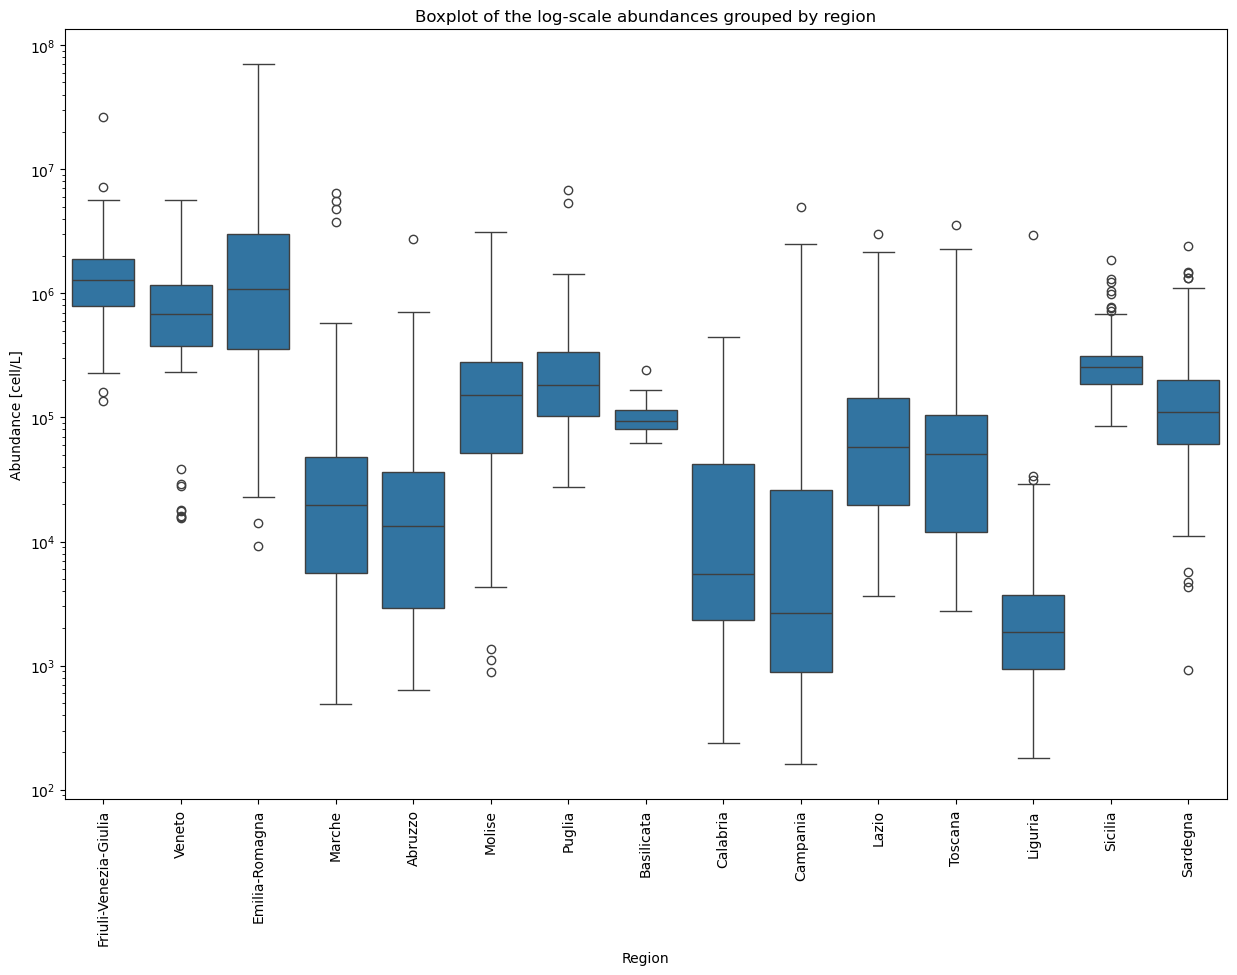

In [8]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
ax.set_yscale("log")
sns.boxplot(
    df.sort_values(by = "Region", key = lambda col: [ordered_regions_dict[item] for item in col.to_list()]), 
    x = "Region", 
    y = "Num_cell_l",
    ax = ax
)
ax.set_ylabel("Abundance [cell/L]")
plt.title("Boxplot of the log-scale abundances grouped by region")
ax.set_xticklabels(labels = ordered_regions, rotation = 90);
plt.savefig("/mnt/d/PHD/ISPRA_20152017_Analysis/Plots/boxplot_abund_by_region.png")

In [9]:
kruskal(*[group["Num_cell_l"].values for  name, group in df.groupby("Region")])

KruskalResult(statistic=1443.9052483500911, pvalue=5.718711261734178e-300)

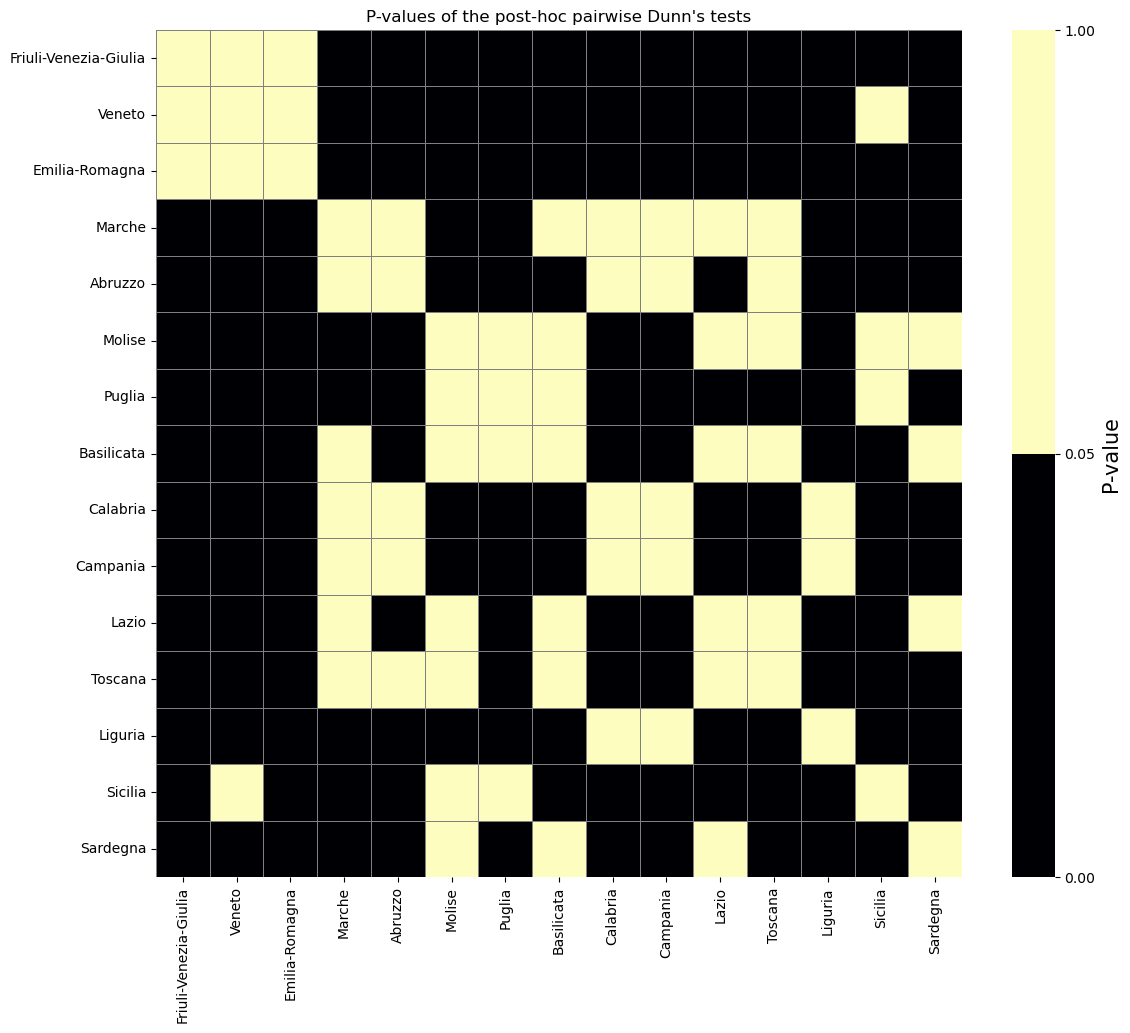

In [13]:
bounds = [0, 0.05, 1]
cm = cmaps.get_cmap("magma").resampled(len(bounds)-1)
norm = mpl.colors.BoundaryNorm(bounds, len(bounds))
p_values = posthoc_dunn(df, group_col = "Region", val_col = "Num_cell_l", p_adjust = "bonferroni")
p_values = p_values.loc[ordered_regions]
p_values = p_values.reindex(sorted(p_values.columns, key = lambda x: ordered_regions_dict[x]), axis = 1)
fig, ax = plt.subplots(1,1, figsize=(13, 11))
sns.heatmap(p_values, 
            ax = ax, cmap = cm, norm = norm, linewidth = 0.5, linecolor = "grey"
                    )
cbar = ax.collections[0].colorbar
cbar.set_label("P-value",size=15)
plt.title("P-values of the post-hoc pairwise Dunn's tests")
plt.savefig("/mnt/d/PHD/ISPRA_20152017_Analysis/Plots/P_val_Dunn__region.png")

/tmp/ipykernel_345/1994080321.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(labels = list(sorted_season.keys())[:-1],rotation = 90)


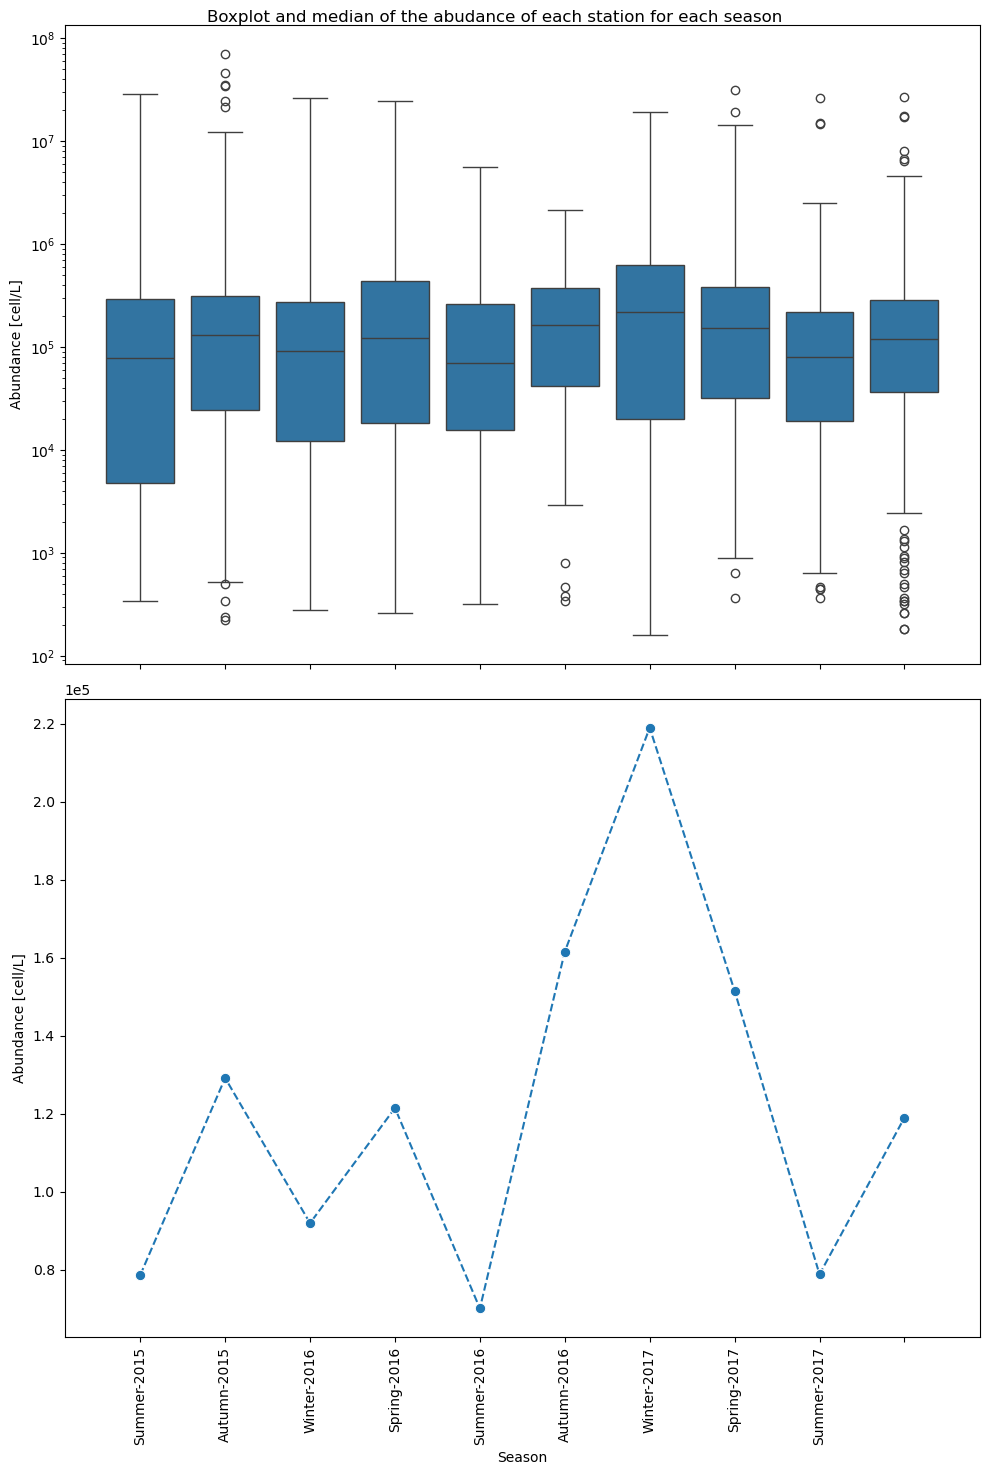

In [42]:
fig, axs = plt.subplots(2,1, figsize=(10,15), sharex = True)
axs[0].set_yscale("log")
sns.boxplot(data = df, x = "Season_year", y = "Num_cell_l", ax = axs[0])
axs[0].set_xlabel(None)
axs[0].set_ylabel("Abundance [cell/L]")
sns.lineplot(data = df.groupby("Season_year", sort = False).median(numeric_only = True), x = "Season_year", y = "Num_cell_l", marker = ".", markersize = 15, linestyle = "dashed", ax = axs[1])
axs[1].set_xticklabels(labels = list(sorted_season.keys())[:-1],rotation = 90)
axs[1].ticklabel_format(axis = "y", style = "sci", scilimits = (0,0))
axs[1].set_ylabel("Abundance [cell/L]")
axs[1].set_xlabel("Season")
#axs[1].set_yscale("log")
plt.suptitle("Boxplot and median of the abudance of each station for each season")
plt.tight_layout()
plt.savefig("/mnt/d/PHD/ISPRA_20152017_Analysis/Plots/Box_median_by_season.png")

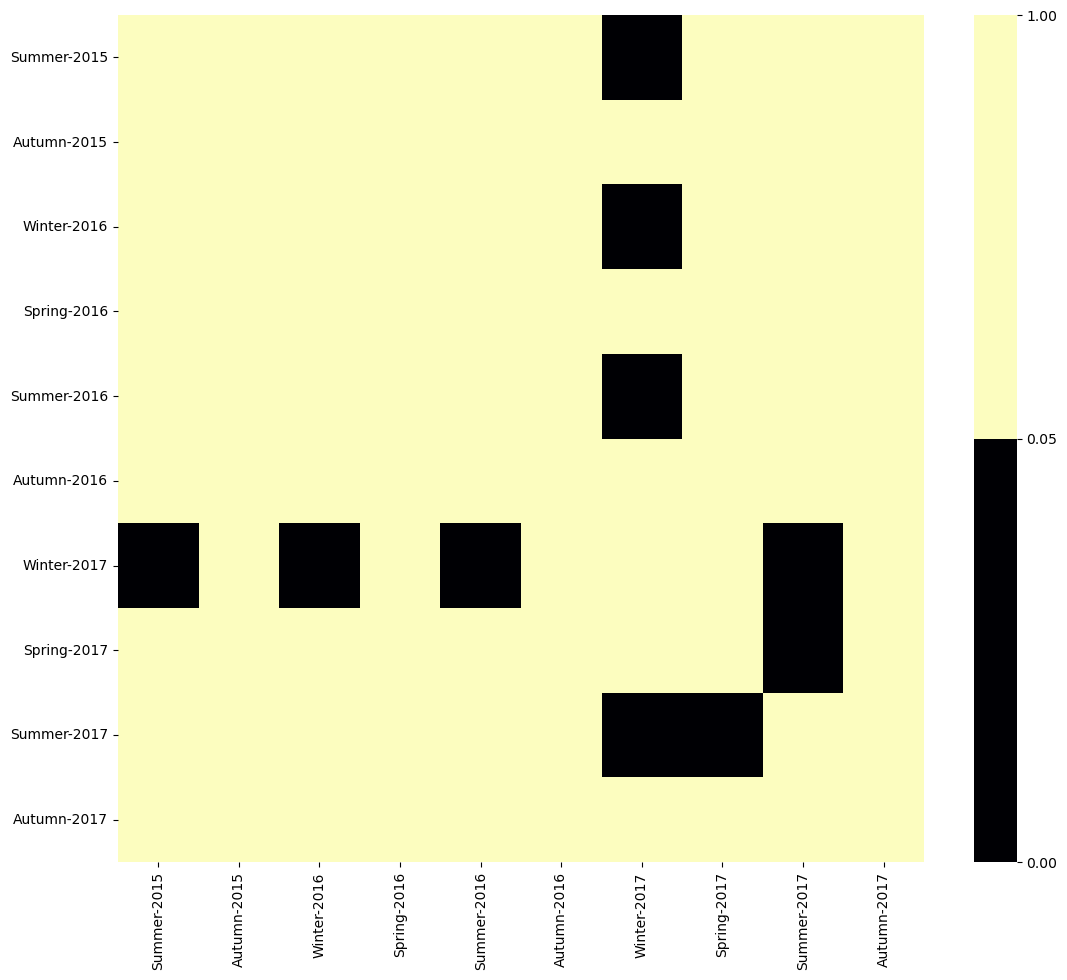

In [43]:
bounds = [0, 0.05, 1]
cm = cmaps.get_cmap("magma").resampled(len(bounds)-1)
norm = mpl.colors.BoundaryNorm(bounds, len(bounds))
p_values = posthoc_dunn(df, group_col = "Season_year", val_col = "Num_cell_l", p_adjust = "bonferroni")
p_values = p_values.loc[list(sorted_season.keys())]
p_values = p_values.reindex(sorted(p_values.columns, key = lambda x: sorted_season[x]), axis = 1)
fig, ax = plt.subplots(1,1, figsize=(13, 11))
sns.heatmap(p_values, 
            ax = ax, cmap = cm, norm = norm,
                    )
cbar = ax.collections[0].colorbar

Text(0.5, 1.0, 'Boxplot of the log-scale abundances grouped by region')

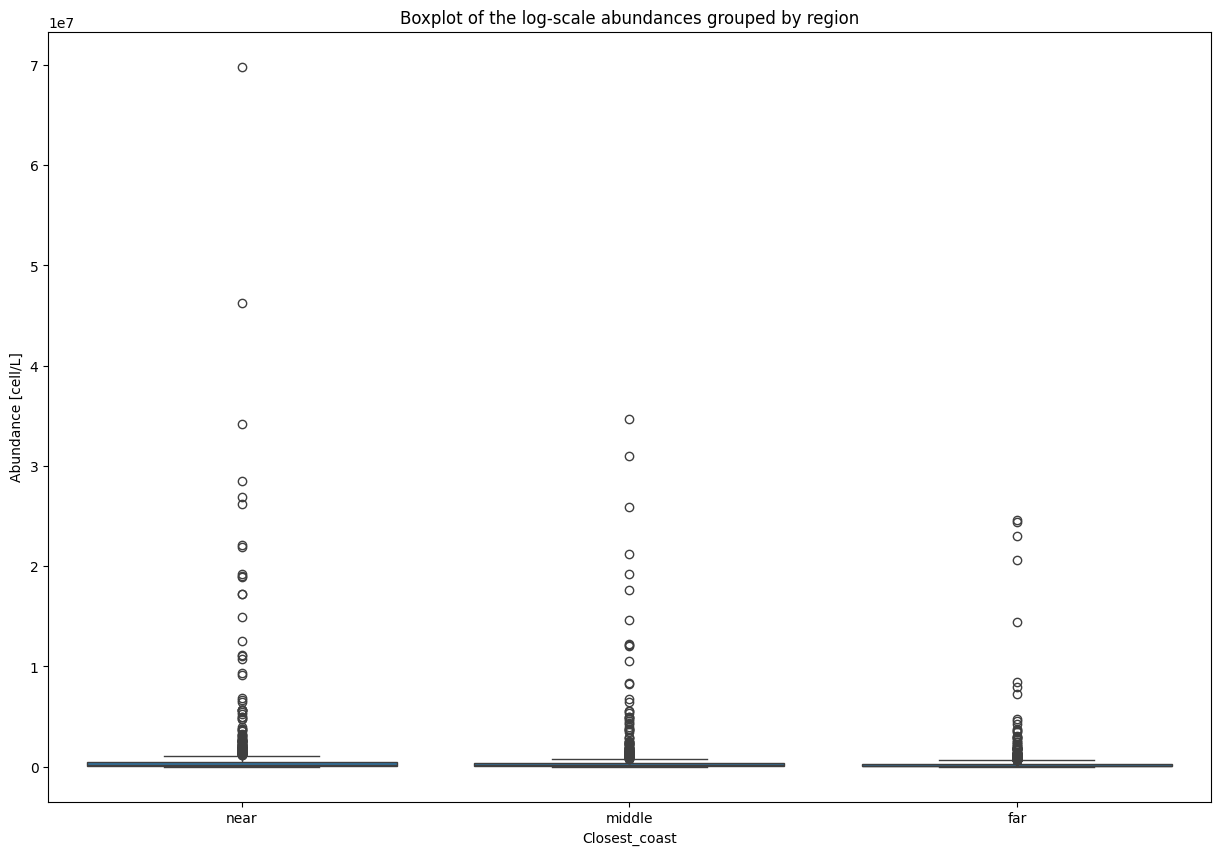

In [68]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
ax.set_yscale("log")
sns.boxplot(
    df, 
    x = "Closest_coast", 
    y = "Num_cell_l",
    ax = ax
)
ax.set_ylabel("Abundance [cell/L]")
plt.title("Boxplot of the log-scale abundances grouped by region")
#ax.set_xticklabels(labels = ordered_regions, rotation = 90);

In [72]:
model = smf.mixedlm("np.log10(Num_cell_l) ~ Closest_coast", df, groups=df["Region"]).fit()
print_model = model.summary()
print(print_model)

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: np.log10(Num_cell_l)
No. Observations: 2223    Method:             REML                
No. Groups:       15      Scale:              0.3591              
Min. group size:  36      Log-Likelihood:     -2061.3055          
Max. group size:  270     Converged:          Yes                 
Mean group size:  148.2                                           
------------------------------------------------------------------
                         Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                4.689    0.214 21.882 0.000  4.269  5.109
Closest_coast[T.middle]  0.126    0.031  4.028 0.000  0.065  0.188
Closest_coast[T.near]    0.265    0.032  8.378 0.000  0.203  0.326
Group Var                0.680    0.432                           



array([datetime.date(2015, 7, 31), datetime.date(2015, 9, 30),
       datetime.date(2015, 11, 30), datetime.date(2016, 1, 31),
       datetime.date(2016, 3, 31), datetime.date(2016, 5, 31),
       datetime.date(2016, 7, 31), datetime.date(2016, 9, 30),
       datetime.date(2016, 11, 30), datetime.date(2017, 1, 31),
       datetime.date(2017, 3, 31), datetime.date(2017, 5, 31),
       datetime.date(2017, 7, 31), datetime.date(2017, 9, 30),
       datetime.date(2017, 11, 30)], dtype=object)

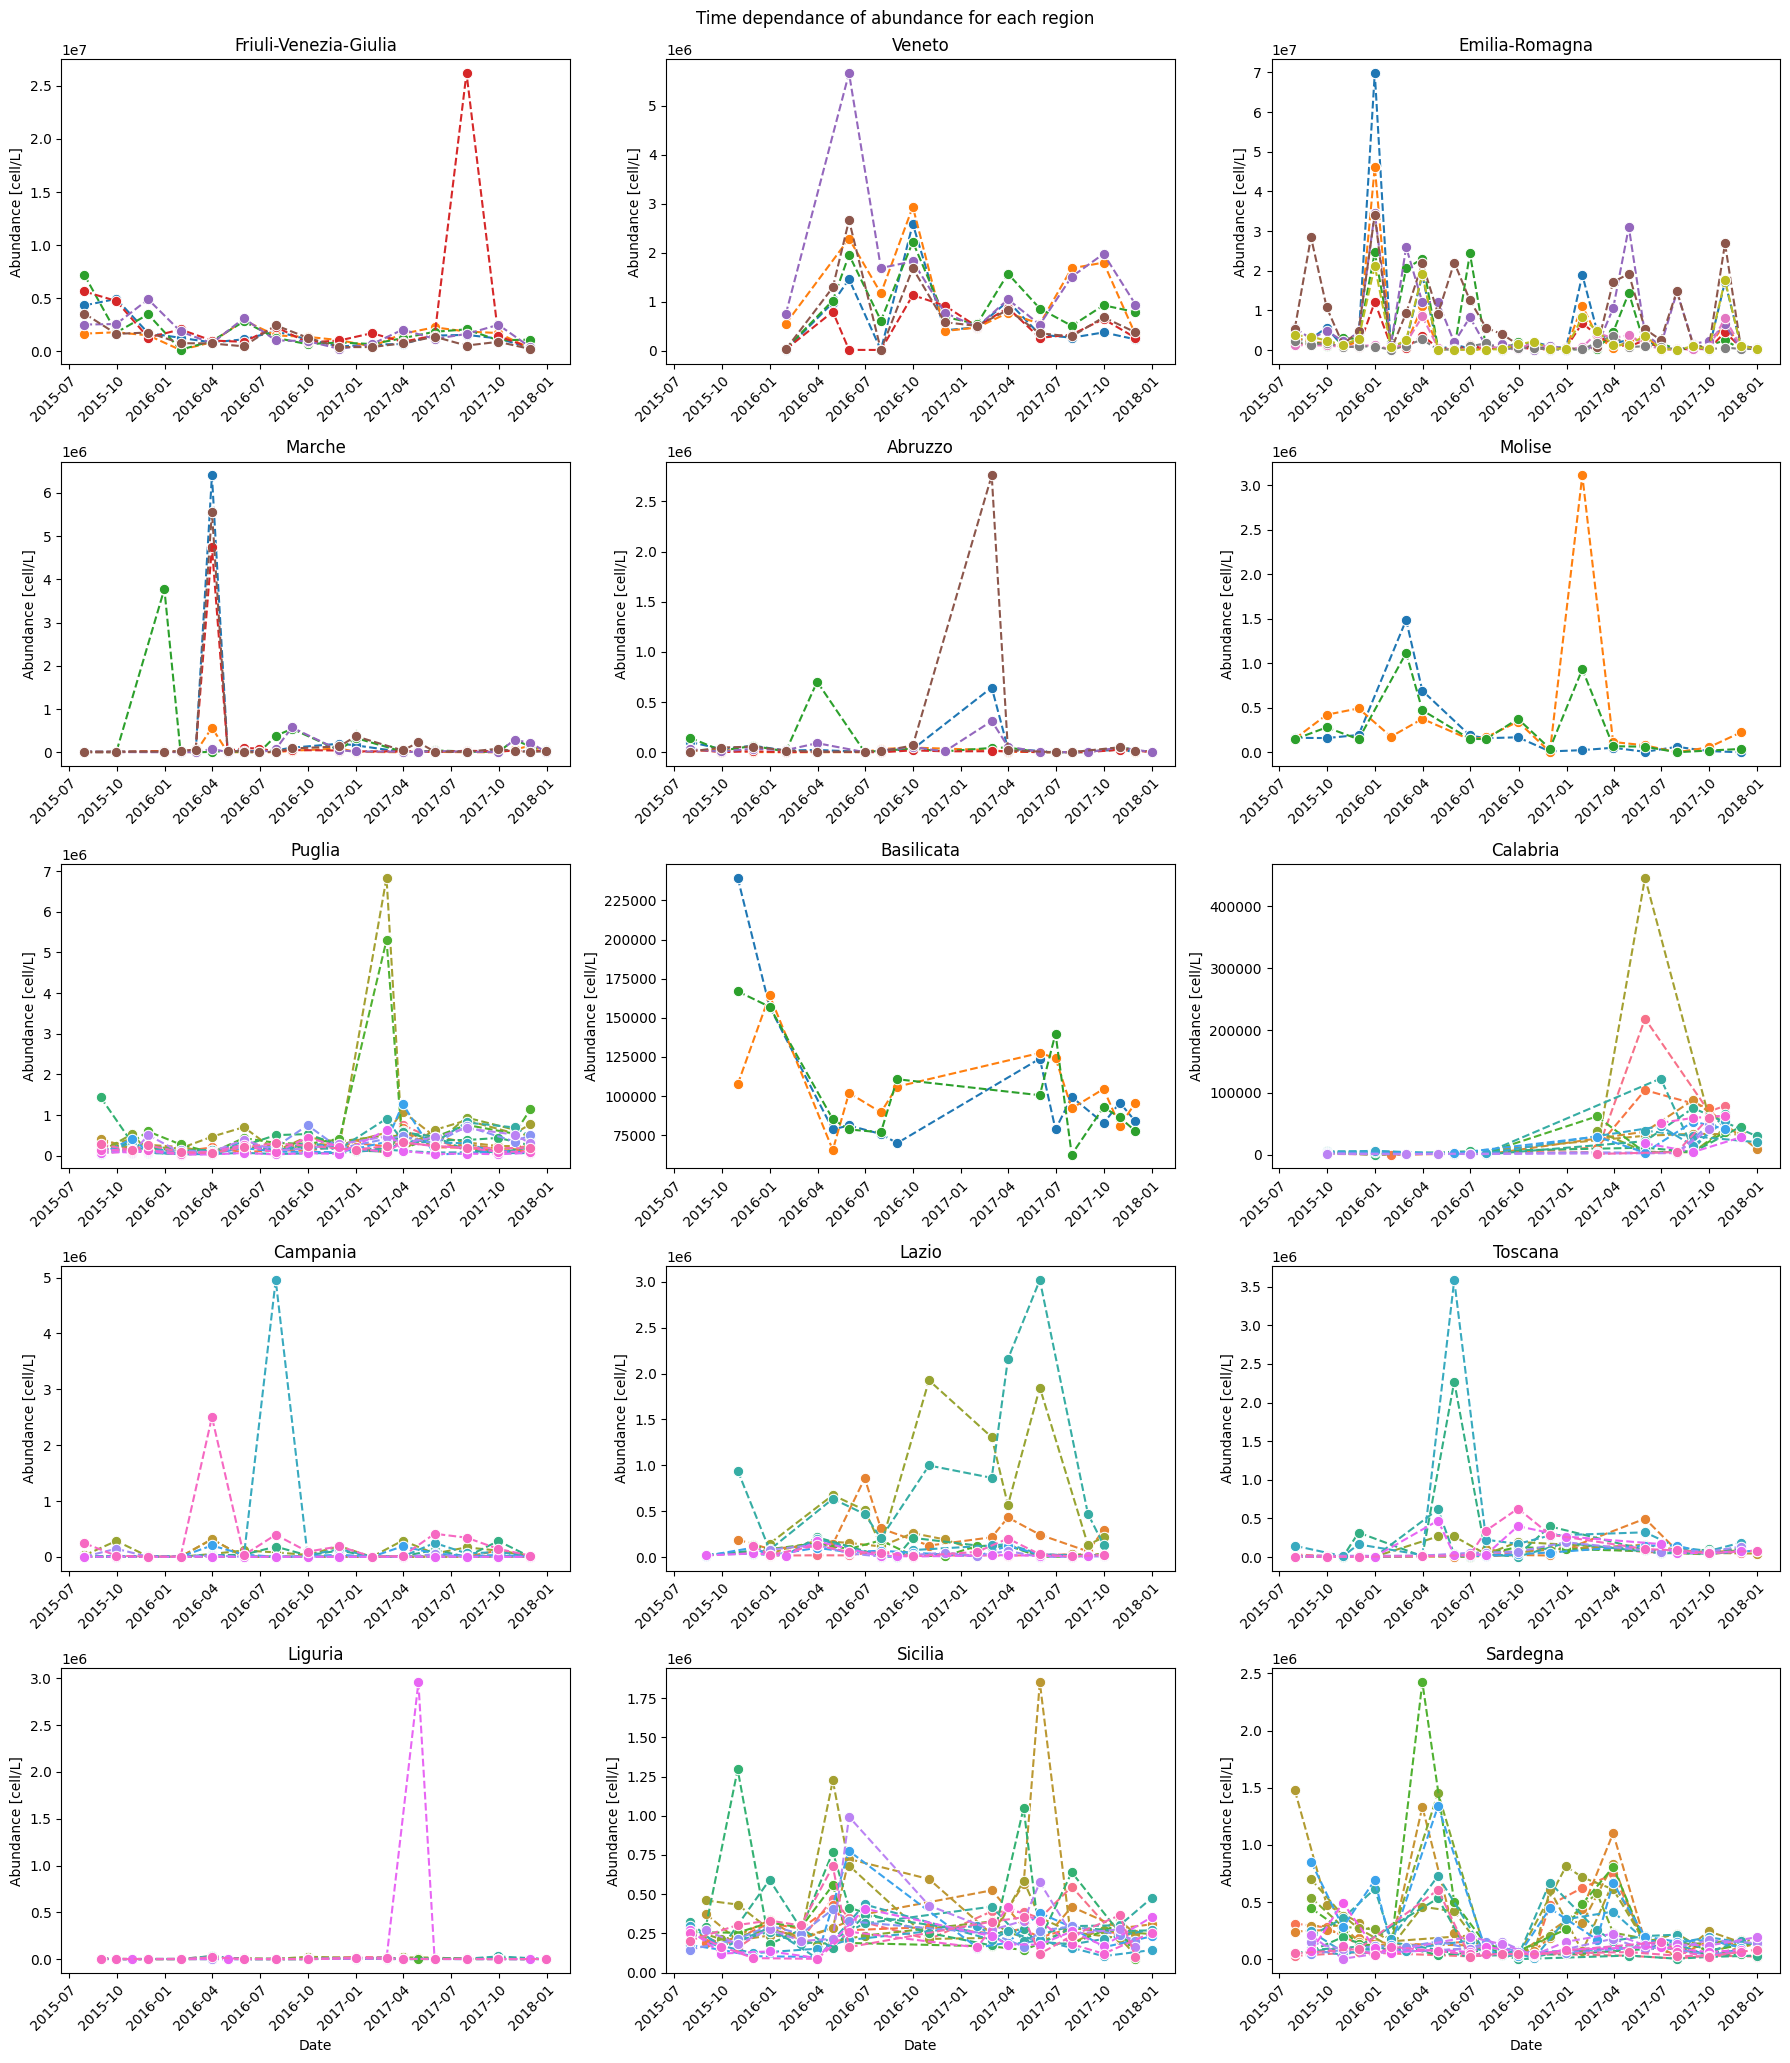

In [30]:
closest_stations = phyto_abundances.loc[phyto_abundances["Closest_coast"] <= 6, ["Region", "id", "Closest_coast"]].drop_duplicates().sort_values(["Region", "Closest_coast"]).iloc[:-2,1].to_numpy()
fig, axs = plt.subplots(5, 3, figsize=(18, 21), sharex=True)
dates = np.sort(df["Date"].unique())
axs = axs.flat
for i, ((group_name, group), ax) in enumerate(zip(df.reset_index().sort_values(by = "Region", key = sorting).groupby("Region", sort=False), fig.axes)): 
    sns.lineplot(data = group, x = "Date", y = "Num_cell_l", hue = "id", marker = ".", markersize = 15, linestyle = "dashed", ax = ax)
    ax.set_title(group_name)
    ax.get_legend().remove()
    ax.xaxis.set_tick_params(labelbottom=True)
    xlabels = ax.get_xticklabels()
    ax.set_xticks(ax.get_xticks().tolist())
    ax.set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
    ax.set_ylabel("Abundance [cell/L]")
#axs[-2].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
#axs[-3].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
fig.suptitle("Time dependance of abundance for each region")
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Abund_time_evol.png")


### looking for blooms

### Some Linear models

In [ ]:
fig, axs = plt.subplots(5, 3, figsize=(18, 18), sharex = True)
axs = axs.flat
for i, ((group_name, group), ax) in enumerate(zip(df.sort_values(by = "Region", key = sorting).groupby("Region", sort=False), fig.axes)): 
    ax.set_yscale("log")
    sns.boxplot(data = group, x = "Season_year", y = "Num_cell_l", ax = ax)
    ax.set_title(group_name)
xlabels = axs[-1].get_xticklabels()
axs[-1].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-2].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-3].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
fig.suptitle("Contribution to the abundance of each taxonomic level (surface level)")
plt.tight_layout(rect=[0, 0, 1, 0.98])

In [74]:
model = smf.mixedlm("np.log10(Num_cell_l) ~ Season_year", df, groups=df["Region"]).fit()
print_model = model.summary()
print(print_model)

                Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  np.log10(Num_cell_l)
No. Observations:  2223     Method:              REML                
No. Groups:        15       Scale:               0.3653              
Min. group size:   36       Log-Likelihood:      -2090.9295          
Max. group size:   270      Converged:           Yes                 
Mean group size:   148.2                                             
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   4.821    0.219 22.059 0.000  4.393  5.250
Season_year[T.Autumn-2016]  0.057    0.064  0.888 0.375 -0.069  0.182
Season_year[T.Autumn-2017]  0.008    0.059  0.135 0.892 -0.108  0.124
Season_year[T.Spring-2016] -0.035    0.058 -0.612 0.541 -0.149  0.078
Season_year[T.Spring-2017]  0.125   

In [ ]:
fig, axs = plt.subplots(5, 3, figsize=(18, 21), sharex = True)
axs = axs.flat
for i, ((group_name, group), ax) in enumerate(zip(df.sort_values(by = "Region", key = sorting).groupby("Region", sort=False), fig.axes)): 
    sns.boxplot(data = group, x = "Season_year", y = "Num_cell_l", ax = ax)
    ax.set_title(group_name)
xlabels = axs[-1].get_xticklabels()
axs[-1].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-2].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-3].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
fig.suptitle("Contribution to the abundance of each taxonomic level (surface level)")
plt.tight_layout(rect=[0, 0, 1, 0.99])

In [ ]:
fig, axs = plt.subplots(5, 3, figsize=(18, 21), sharex = True)
axs = axs.flat
for i, ((group_name, group), ax) in enumerate(zip(df.reset_index().sort_values(by = "Region", key = sorting).query(
    "id in @closest_stations"
).groupby("Region", sort=False), fig.axes)): 
    #ax.set_yscale("log")
    sns.lineplot(data = group, x = "Date", y = "Num_cell_l", hue = "id", marker = ".", markersize = 15, linestyle = "dashed", ax = ax)
    ax.set_title(group_name)
    ax.get_legend().remove()
xlabels = axs[-1].get_xticklabels()
axs[-1].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-2].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-3].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
fig.suptitle("Contribution to the abundance of each taxonomic level (surface level)")
plt.tight_layout(rect=[0, 0, 1, 0.99])

In [ ]:
closest_stations = phyto_abundances.loc[phyto_abundances["Closest_coast"] <= 6, ["Region", "id", "Closest_coast"]].drop_duplicates().sort_values(["Region", "Closest_coast"]).iloc[:-2,1].to_numpy()
fig, axs = plt.subplots(5, 3, figsize=(18, 21), sharex = True)
axs = axs.flat
for i, ((group_name, group), ax) in enumerate(zip(df.reset_index().sort_values(by = "Region", key = sorting).query(
    "id in @closest_stations"
).groupby("Region", sort=False), fig.axes)): 
    ax.set_yscale("log")
    sns.lineplot(data = group, x = "Date", y = "Num_cell_l", hue = "id", marker = ".", markersize = 15, linestyle = "dashed", ax = ax)
    ax.set_title(group_name)
    ax.get_legend().remove()
xlabels = axs[-1].get_xticklabels()
axs[-1].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-2].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-3].set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45); 
fig.suptitle("Contribution to the abundance of each taxonomic level (surface level)")
plt.tight_layout(rect=[0, 0, 1, 0.99])

In [81]:
model = smf.mixedlm("np.log10(Num_cell_l) ~ Date", df, groups=df["Region"]).fit()
print_model = model.summary()
print(print_model)

                       Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      np.log10(Num_cell_l)
No. Observations:        2223         Method:                  REML                
No. Groups:              15           Scale:                   0.3461              
Min. group size:         36           Log-Likelihood:          -2049.5350          
Max. group size:         270          Converged:               Yes                 
Mean group size:         148.2                                                     
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                 4.764    0.228 20.936 0.000  4.318  5.210
Date[T.Timestamp('2015-08-31 00:00:00')]  0.111    0.103  1.079 0.281 -0.091  0.314
Date[T.Timestam

In [77]:
model = smf.ols(formula='np.log(Num_cell_l) ~ Region', data=df).fit()
print_model = model.summary()

In [87]:
df.to_csv(_HOME_ + "/PHD/ISPRA_20152017_Analysis/out.csv")

In [ ]:
fig, axs = plt.subplots(5, 3, figsize=(18, 21))
axs = axs.flat
#x_ticks = [-0.5, 0, 2, 4, 6, 8, 10]
#x_labels =  ["", "Summer-2015", 'Winter-2016', 'Summer-2016', "Winter-2017", 'Summer-2017', "Winter-2018"]
pos_season = {
    "Summer" : 0,
    "Autumn" : 1,
    "Winter" : 2, 
    "Spring" : 3
}
fig.delaxes(axs[-1])
for (group_name, group), ax in zip(df.sort_values(by = "Region", key = sorting).groupby("Region", sort = False), axs): 
    #group.set_index("Season", inplace = True)
    #ax.boxplot(positions = [pos_season[ind] for ind in group.index.unique()], x = [group.loc[ind, "Num_cell_l"].to_numpy() for ind in group.index.unique()]);
    ax.set_title(group_name)
    #ax.set_xticks(x_ticks, x_labels, rotation = 90)
    #ax.set_yscale("log")
    #ax.set_xlabel(None)
    #ax.set_ylabel(None)
    #ax.tick_params(axis='x', rotation=90)
    sns.boxplot(data = group, x = "Season", y = "Num_cell_l", ax = ax)
xlabels = axs[-1].get_xticklabels()
axs[-1].set_xticklabels(list(pos_season.keys()), ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-2].set_xticklabels(list(pos_season.keys()), ha = "right", rotation_mode = "anchor", rotation = 45); 
axs[-3].set_xticklabels(list(pos_season.keys()), ha = "right", rotation_mode = "anchor", rotation = 45); 
fig.supxlabel("Season")
fig.supylabel(r"Abundance ($ind. / l$)")
fig.suptitle("Boxplot of the seasonal abundance for each region")
plt.tight_layout()

## Contribution to the abundance for each cathegory

In [13]:
phyto_abund_category = phyto_abund_simplified.copy()
phyto_abund_category["Det_level"] = "Species"
phyto_abund_category.loc[phyto_abund_category["Genus"] == "Other", "Det_level"] = "Unknown"
phyto_abund_category.loc[phyto_abund_category["Taxon"].str.contains("indet") & ~phyto_abund_category["Taxon"].str.contains("Other"), "Det_level"] = "Higher cat."
phyto_abund_category.loc[phyto_abund_category["Taxon"].str.contains("spp."), "Det_level"] = "Genus"
#phyto_abund_category.loc[phyto_abund_category["Det_level"].isna(), "Det_level"] = "Species"
#phyto_abund_category.loc[phyto_abund_category["Det_level"] == "Genus", "Taxon"] = phyto_abund_category.loc[phyto_abund_category["Det_level"] == "Genus", "Genus"]
#phyto_abund_category = phyto_abund_category.groupby(["Region", "Det_level"]).agg({"Num_cell_l" : "sum", "Taxon" : "nunique"}).reset_index()

## pie chart 

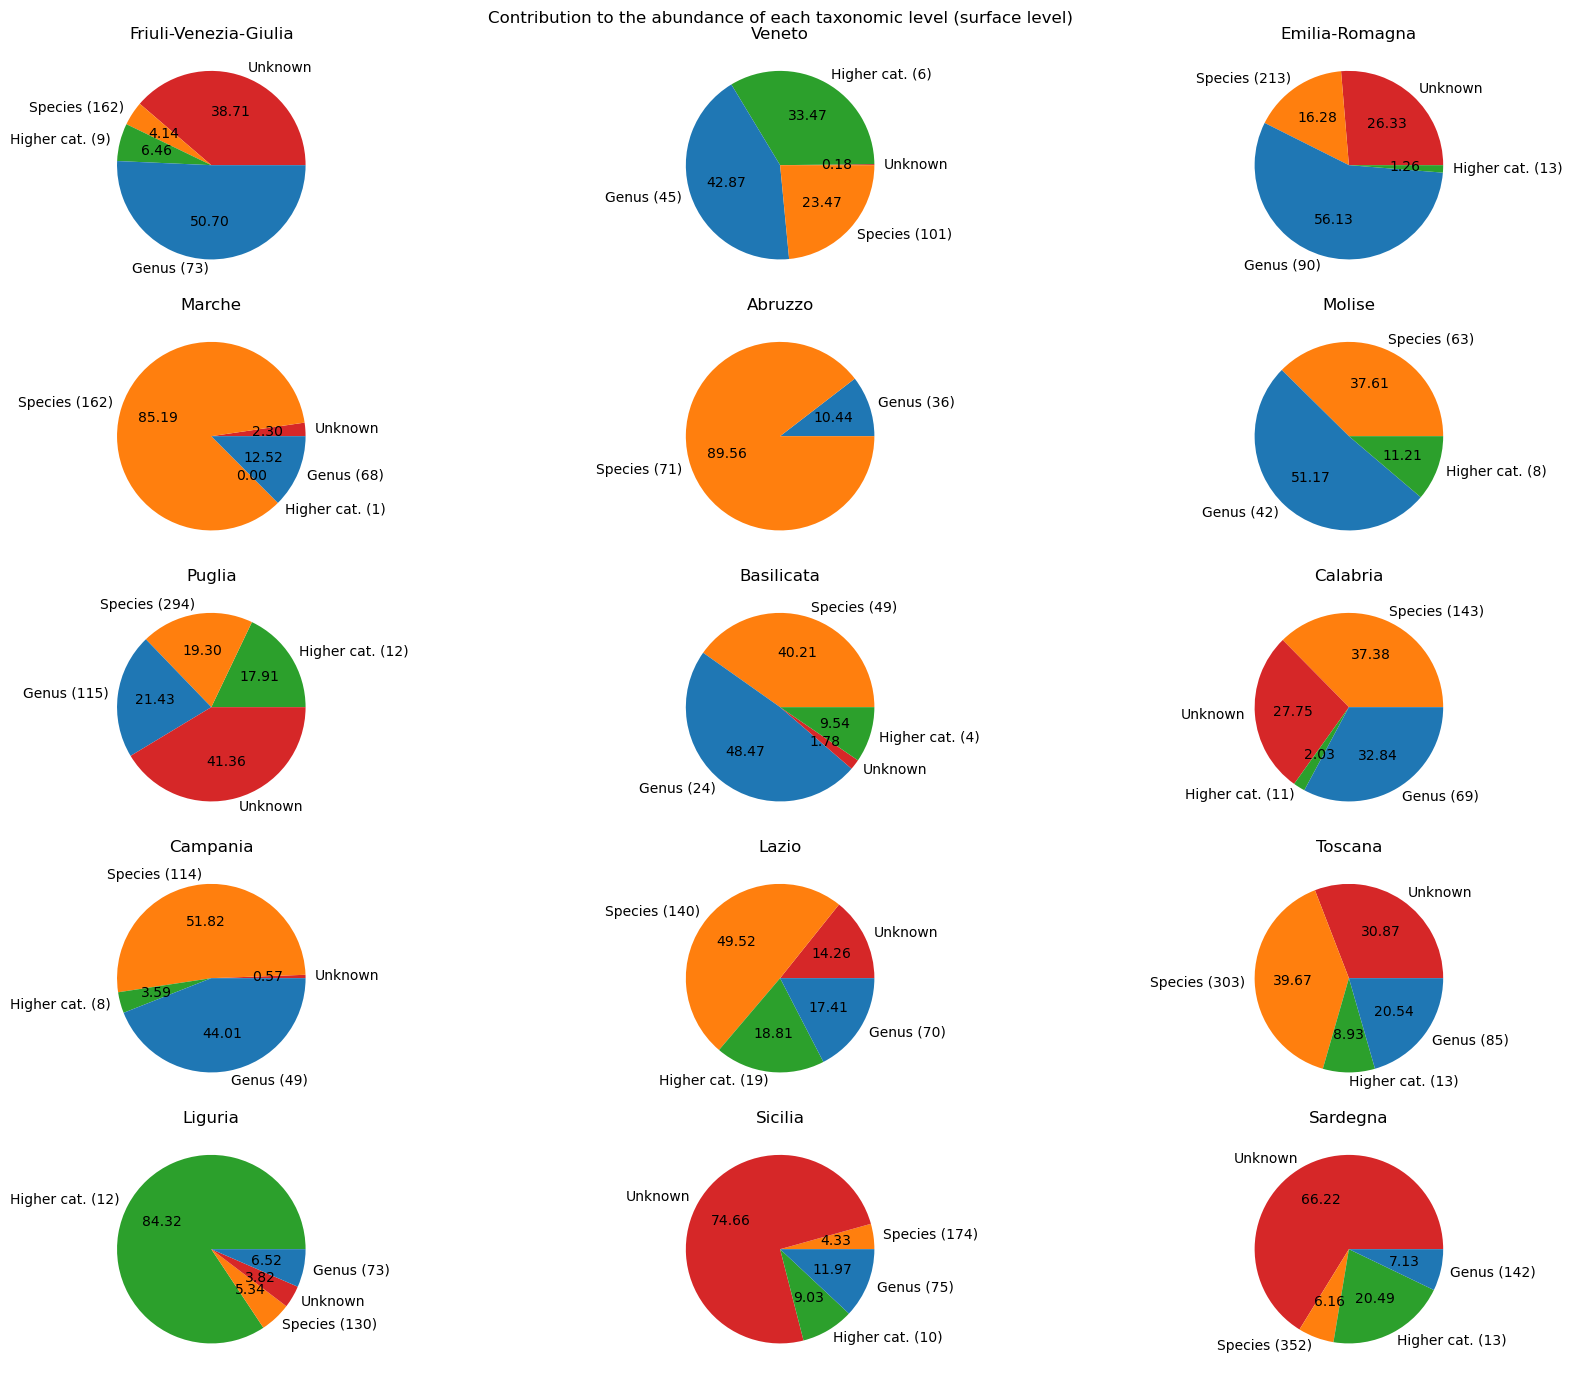

In [8]:
colours = {'Genus': 'C0', 'Species': 'C1', 'Unknown': 'C3', 'Higher cat.': 'C2'}
fig, axs = plt.subplots(5, 3, figsize=(18, 14)) #5
axs = axs.flat
sorting = lambda col: [ordered_regions_dict[item] for item in col.to_list()]

abund_aggregated = phyto_abund_category.groupby(["Region", "Det_level"]).agg({"Num_cell_l" : "sum", "Taxon" : "nunique"}).reset_index(
    ).sort_values(by = "Region", key = sorting).groupby("Region", sort=False)

for i, ((group_name, group), ax) in enumerate(zip(abund_aggregated, fig.axes)): 
    labels = []
    for i, j in group[["Det_level", "Taxon"]].to_numpy(): 
        if i != "Unknown":
            labels += [f"{i} ({j})"]
        else: 
            labels += [f"{i}"]
    ax.pie(group["Num_cell_l"].to_numpy(), labels = labels, colors= [colours[key] for key in group["Det_level"].to_numpy()], autopct='%.2f')
    ax.set_title(group_name)
fig.suptitle("Contribution to the abundance of each taxonomic level (surface level)")
plt.tight_layout()
plt.savefig("/mnt/d/PHD/ISPRA_20152017_Analysis/Plots/Category_contribution_surf.png")

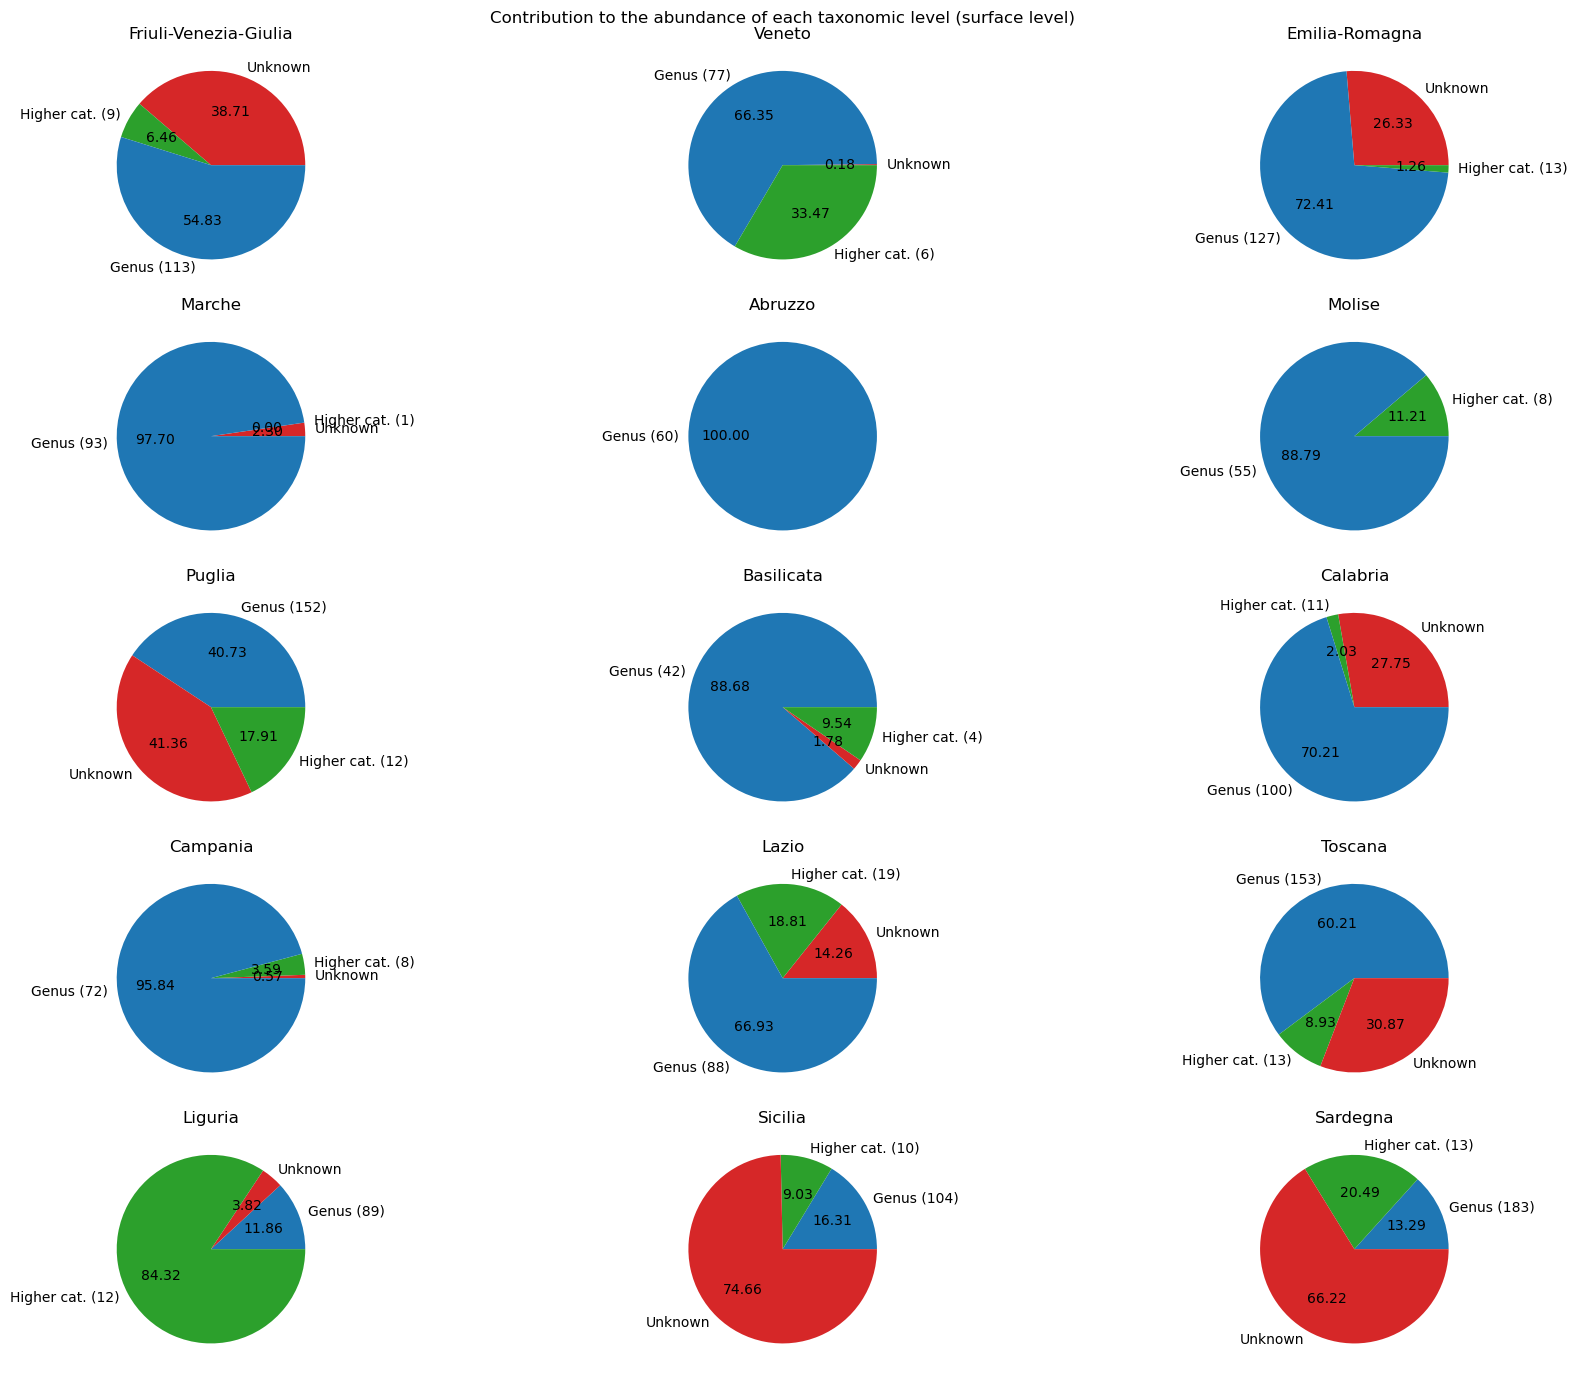

In [11]:
colours = {'Genus': 'C0', 'Species': 'C1', 'Unknown': 'C3', 'Higher cat.': 'C2'}
fig, axs = plt.subplots(5, 3, figsize=(18, 14)) #5
axs = axs.flat
sorting = lambda col: [ordered_regions_dict[item] for item in col.to_list()]
abund_aggregated = phyto_abund_category
abund_aggregated.loc[abund_aggregated["Det_level"] == "Species", "Det_level"] = "Genus"
abund_aggregated.loc[abund_aggregated["Det_level"] == "Genus", "Taxon"] = abund_aggregated.loc[abund_aggregated["Det_level"] == "Genus", "Genus"]
abund_aggregated = abund_aggregated.groupby(["Region", "Det_level"]).agg({"Num_cell_l" : "sum", "Taxon" : "nunique"}).reset_index(
    ).sort_values(by = "Region", key = sorting).groupby("Region", sort=False)
for i, ((group_name, group), ax) in enumerate(zip(abund_aggregated, fig.axes)): 
    labels = []
    for i, j in group[["Det_level", "Taxon"]].to_numpy(): 
        if i != "Unknown":
            labels += [f"{i} ({j})"]
        else: 
            labels += [f"{i}"]
    ax.pie(group["Num_cell_l"].to_numpy(), labels = labels, colors= [colours[key] for key in group["Det_level"].to_numpy()], autopct='%.2f')
    ax.set_title(group_name)
fig.suptitle("Contribution to the abundance of each taxonomic level (surface level)")
plt.tight_layout()
plt.savefig("/mnt/d/PHD/ISPRA_20152017_Analysis/Plots/Category_contribution_surf_only_genus.png")

## barplot 

/tmp/ipykernel_726/2857240827.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45);


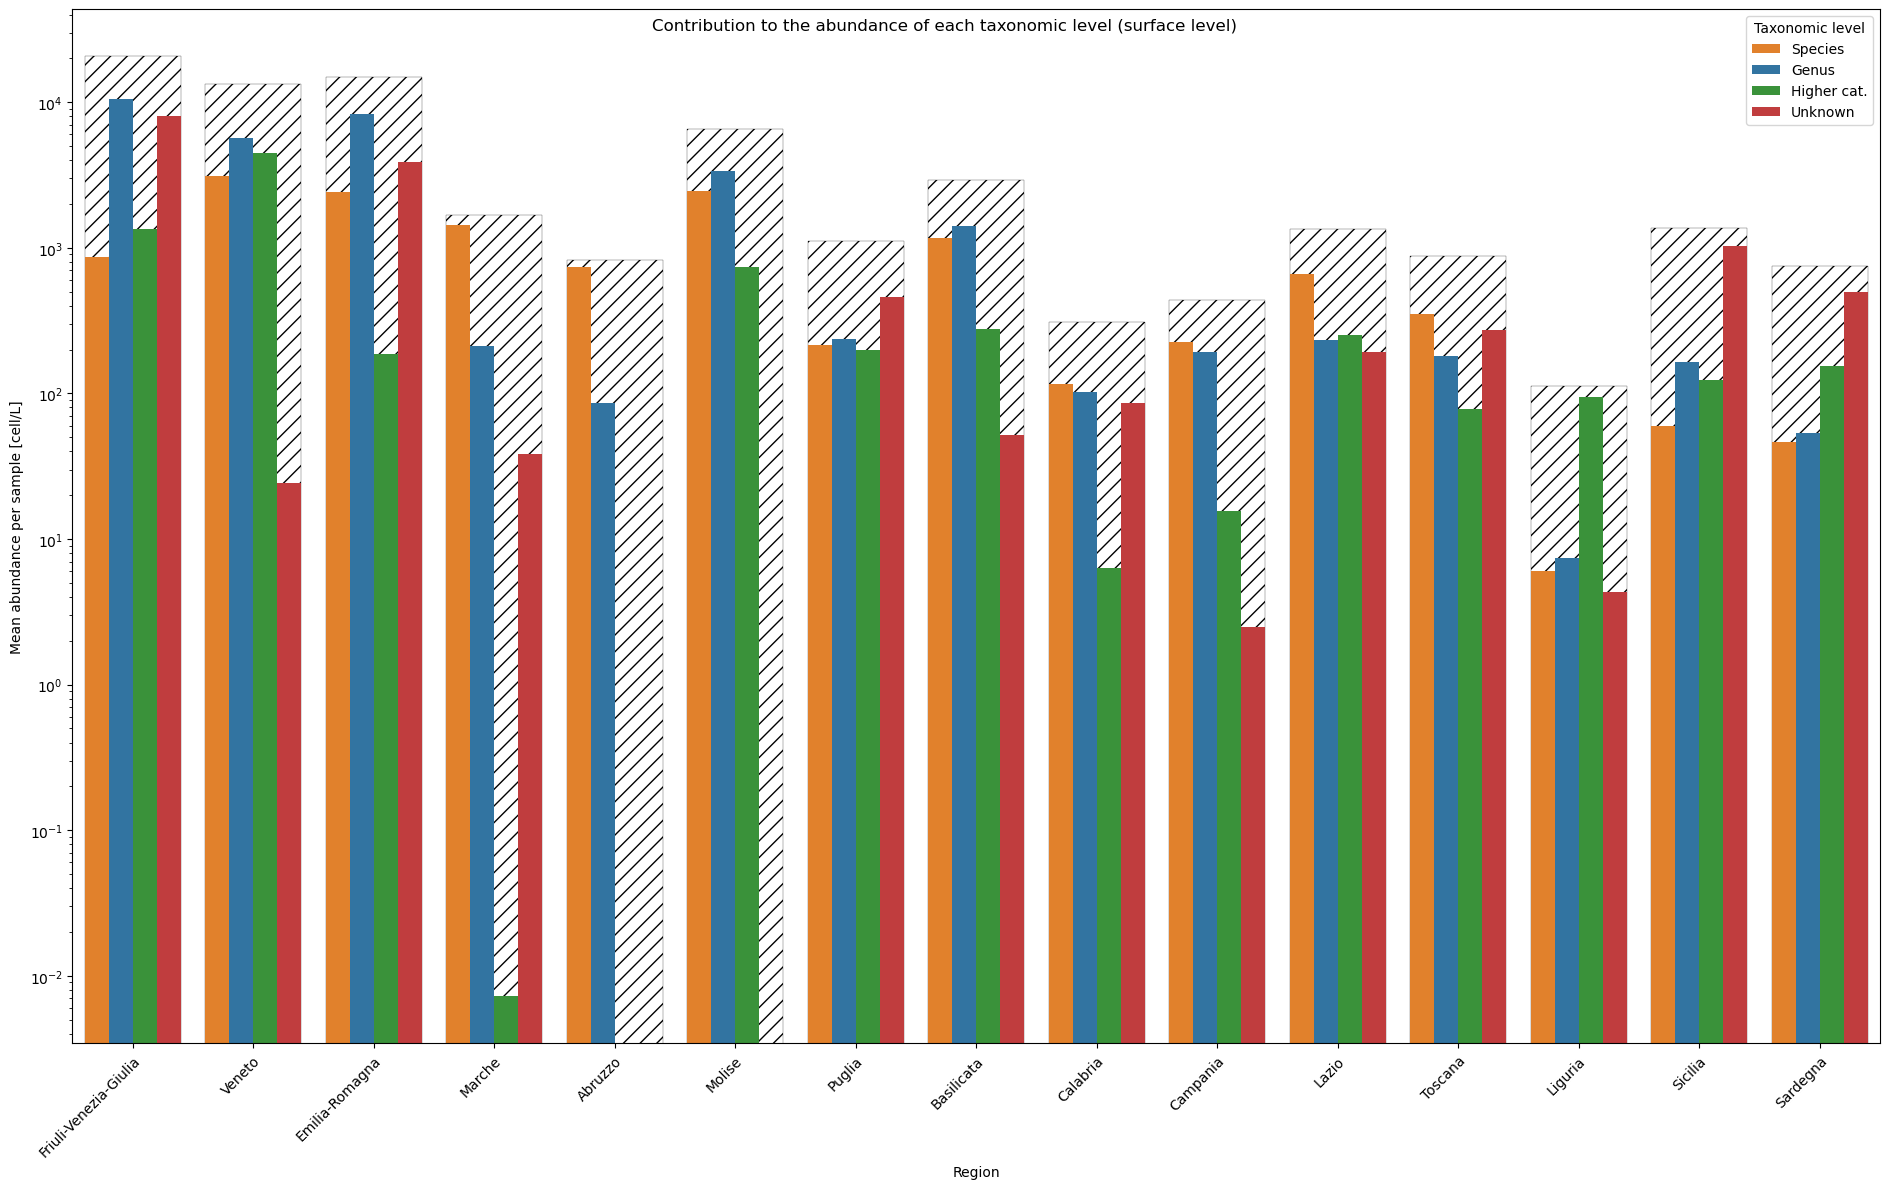

In [32]:
colours = {'Genus': 'C0', 'Species': 'C1', 'Unknown': 'C3', 'Higher cat.': 'C2'}
ordered_cat = {"Species" : 0, "Genus" : 1, "Higher cat." : 2, "Unknown" : 3}
#sorting_reg = lambda col: [ordered_regions_dict[item] for item in col.to_list()]
#sorting_cat = lambda col: [ordered_cat[item] for item in col.to_list()]
fig, ax = plt.subplots(1, 1, figsize=(19, 12))
df = phyto_abund_category.groupby(["Region", "Det_level"]).agg({"Num_cell_l" : "sum", "Taxon" : "nunique"}).reset_index()
samples = phyto_abund_category[["Region", "id", "Date"]].groupby(["Region", "id"]).nunique().reset_index().groupby("Region").sum(numeric_only=True).rename(columns={"Date" : "Num_cell_l"})
df["Num_cell_l"] = df[["Region", "Num_cell_l"]].set_index("Region").div(samples).loc[:, "Num_cell_l"].to_numpy()
df["Region"] = pd.Categorical(df["Region"], ordered=True, categories=ordered_regions)
df["Det_level"] = pd.Categorical(df["Det_level"], ordered=True, categories=ordered_cat.keys())
df["Num_cell_l"] = df[["Region", "Num_cell_l"]].set_index("Region").div(samples).loc[:, "Num_cell_l"].to_numpy()
samples = phyto_abund_category[["Region", "id", "Date"]].groupby(["Region", "id"]).nunique().reset_index().groupby("Region").sum(numeric_only=True).rename(columns={"Date" : "Num_cell_l"})
df.rename(columns={"Det_level" : "Taxonomic level"}, inplace=True)
bars = sns.barplot(df.groupby("Region").sum(numeric_only=True).reset_index(), x = "Region", y = "Num_cell_l", ax = ax, color= "white", width = 0.8, linewidth = 0.2, edgecolor = "k")
for bar in bars.patches: 
    bar.set_hatch("//")
sns.barplot(df, x="Region", y="Num_cell_l", hue = "Taxonomic level", palette = colours, ax = ax, width = 0.8)
ax.set_yscale("log")
ax.set_ylabel("Mean abundance per sample [cell/L]")
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor", rotation = 45);
plt.tight_layout()
plt.suptitle("Contribution to the abundance of each taxonomic level (surface level)")
plt.savefig("/mnt/d/PHD/ISPRA_20152017_Analysis/Plots/Cat_contribution_barplot.png")

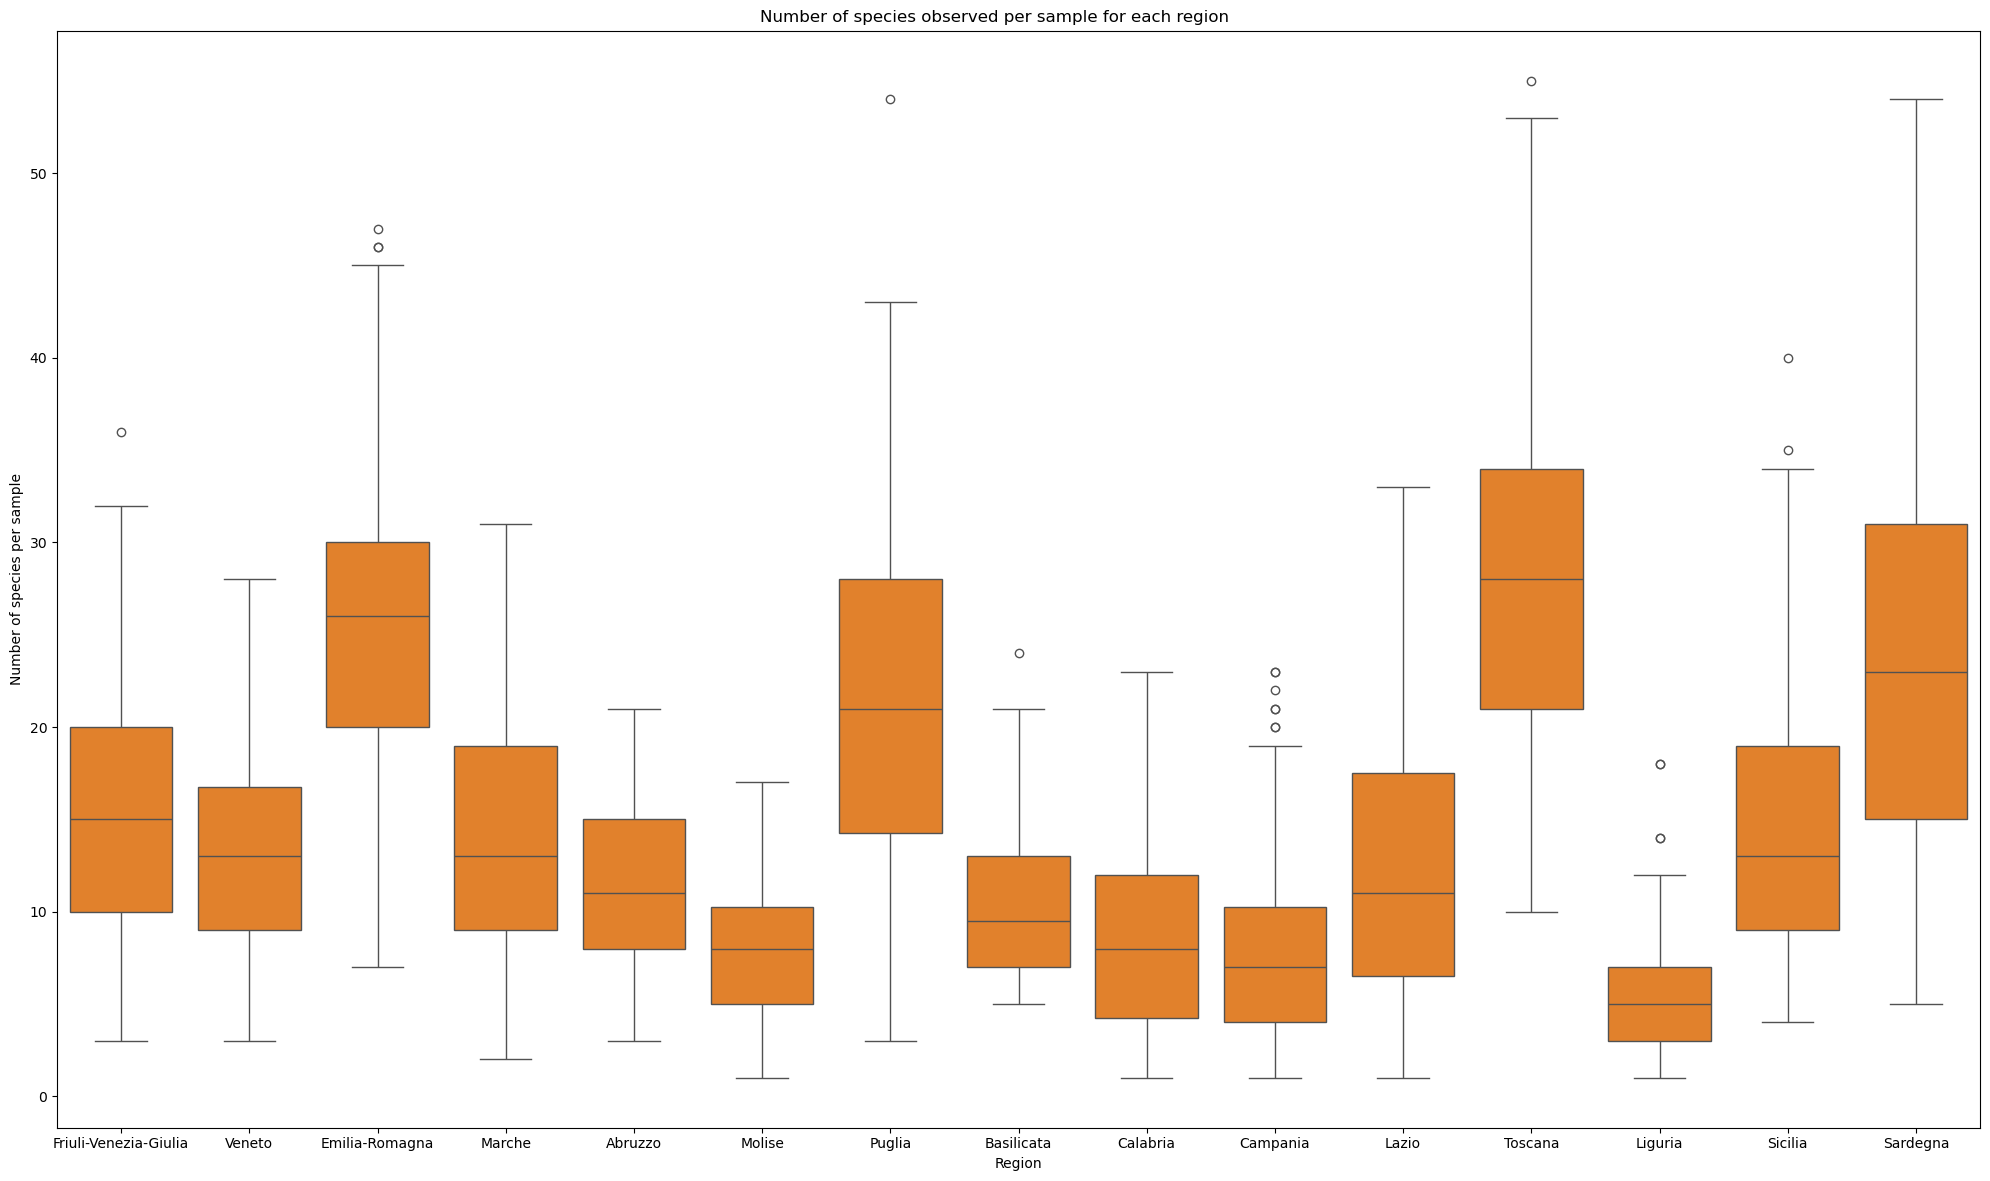

In [57]:
species = phyto_abund_category.query("Det_level == 'Species'")[["Region", "id", "Date", "Taxon"]]
species = species.groupby(["Region", "id", "Date"]).count().reset_index()
species["Region"] = pd.Categorical(species["Region"], ordered=True, categories=ordered_regions)
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
sns.boxplot(species, x = "Region", y = "Taxon", color = "C1")
ax.set_ylabel("Number of species per sample")
plt.suptitle("Number of species observed per sample for each region")
plt.tight_layout()
plt.savefig("/mnt/d/PHD/ISPRA_20152017_Analysis/Plots/N_species_per_sample_by_region.png")

## Composition Analysis 

In [45]:
species_abund = phyto_abund_category.query("Det_level == 'Species'")

In [47]:
#unique species
len(species_abund["Taxon"].unique())

666

In [50]:
species_freq = species_abund.loc[:, "Taxon"].value_counts().reset_index()
for fraction in [0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 0.95, 1]: 
    print(species_freq["count"].quantile(fraction))

1.0
2.0
3.0
5.0
8.0
42.75
270.0
1292.0


In [85]:
freq_rare = 2
rare_species = species_freq.loc[species_freq["count"] <= freq_rare, "Taxon"].unique()

0       True
1       True
2       True
3       True
4       True
       ...  
661    False
662    False
663    False
664    False
665    False
Name: count, Length: 666, dtype: bool

In [60]:
common_species = species_freq[species_freq['count'] > species_freq['count'].quantile(0.95)]
print(f"number of species above the 95 quantile = {len(common_species)}")
common_species

number of species above the 95 quantile = 34


,Taxon,count
0,Proboscia alata,1292
1,Cylindrotheca closterium,1114
2,Thalassionema nitzschioides,1041
3,Dactyliosolen fragilissimus,990
4,Leptocylindrus danicus,838
5,Cerataulina pelagica,822
6,Prorocentrum micans,794
7,Guinardia striata,793
8,Gyrodinium fusiforme,755
9,Ceratium furca,743


In [62]:
#in che regioni le specie più frequenti non sono state viste TODO
where_common_not_found = {}
for species in common_species:
    regions_no_obs = set(ordered_regions).difference(set(species_abund["Region"]))
    if regions_no_obs: 
        where_common_not_found[species] = list(regions_no_obs)
np.unique(list(itertools.chain(*where_common_not_found.values())), return_counts=True)

In [64]:
species_median_abund = species_abund[["Taxon", "Num_cell_l"]].groupby("Taxon").median().sort_values("Num_cell_l", ascending=False)["Num_cell_l"]
abund_species = species_median_abund[species_median_abund > species_median_abund.quantile(0.95)]
abund_species

Taxon
Chaetoceros delicatulus                117652.000000
Dinobryon coalescens                    22678.000000
Cyclotella meneghiniana                 13606.500000
Plagioselmis prolonga                   12344.000000
Cyclotella glomerata                    11339.000000
Cyclotella caspia                       11339.000000
Oltmannsiella lineata                    9071.000000
Paulinella ovalis                        8637.000000
Skeletonema mediterraneum                7401.000000
Tetrastrum triangulare                   6038.000000
Planktothrix rubescens                   5880.000000
Gyrosigma fusiforme                      5467.000000
Ollicola vangoori                        4319.000000
Chaetoceros compressus                   3420.000000
Chaetoceros throndsenii                  3019.000000
Chaetoceros neglectus                    2958.500000
Skeletonema tropicum                     2800.000000
Pseudonitzschia delicatissima            2480.000000
Bacteriastrum parallelum                

In [90]:
species_abund.loc[(species_abund["Num_cell_l"] < 100) & (species_abund["Region"] == "Sardegna"), 
                  "Num_cell_l"].unique()

array([10., 50., 40., 20., 60., 80., 90., 30., 70., 25.,  5., 15., 55.,
       35., 45.])

<Axes: xlabel='Num_cell_l', ylabel='Count'>

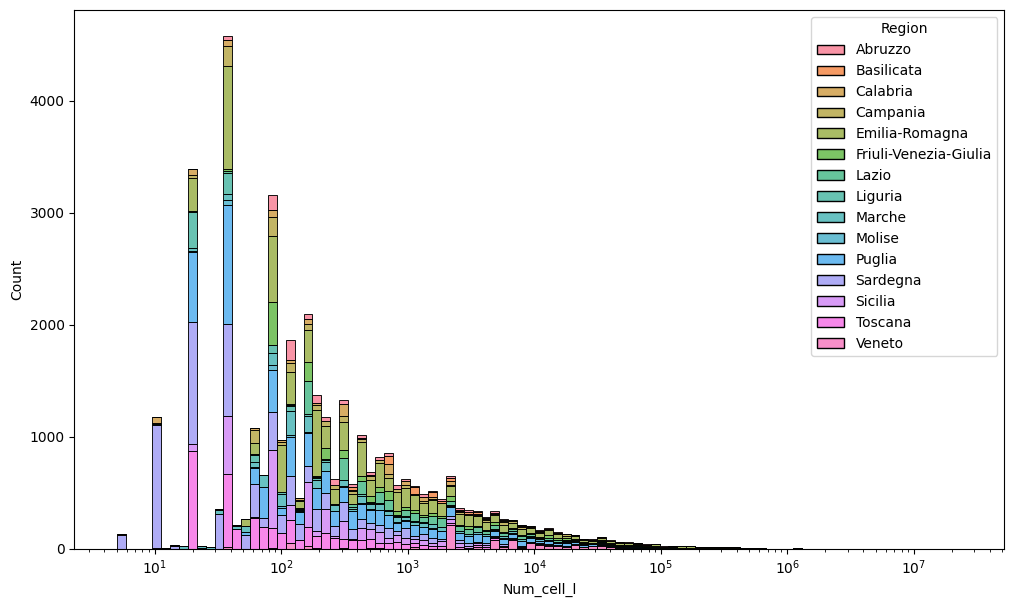

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.set_xscale("log")
sns.histplot(data = species_abund, 
             x = "Num_cell_l", 
             hue = "Region",
             multiple="stack",
             ax = ax
             )

In [98]:
species_abund.loc[species_abund["Num_cell_l"] < 100, :].groupby("Num_cell_l").count().reset_index()

,Num_cell_l,Region,id,Longitude,Latitude,Date,Sample_depth,Genus,Taxon,Closest_coast,Det_level
0,5.0,137,137,137,137,137,137,137,137,137,137
1,10.0,1175,1175,1175,1175,1175,1175,1175,1175,1175,1175
2,11.0,5,5,5,5,5,5,5,5,5,5
3,12.0,3,3,3,3,3,3,3,3,3,3
4,13.0,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...
85,95.0,24,24,24,24,24,24,24,24,24,24
86,96.0,7,7,7,7,7,7,7,7,7,7
87,97.0,9,9,9,9,9,9,9,9,9,9
88,98.0,5,5,5,5,5,5,5,5,5,5


<Axes: xlabel='Num_cell_l', ylabel='Region'>

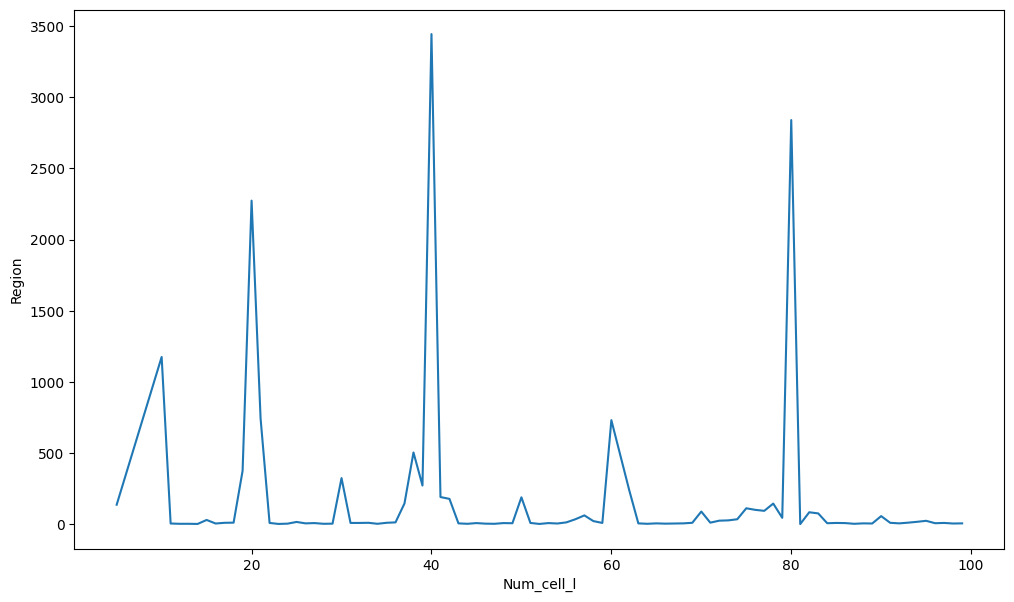

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.lineplot(data = species_abund.loc[species_abund["Num_cell_l"] < 100, :].groupby("Num_cell_l").count().reset_index(), 
             y = "Region",
             x = "Num_cell_l", 
             ax = ax
             )


<Axes: xlabel='Num_cell_l', ylabel='Count'>

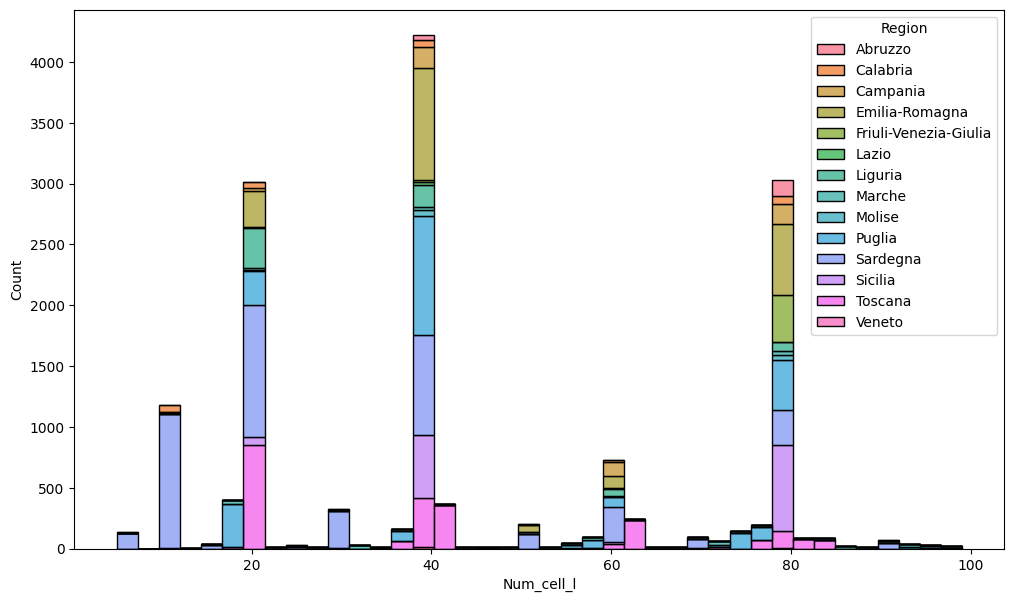

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
#ax.set_xscale("log")
sns.histplot(data = species_abund.loc[species_abund["Num_cell_l"] < 100, :], 
             x = "Num_cell_l", 
             hue = "Region",
             multiple="stack",
             bins = 40,
             ax = ax
             )

<Axes: xlabel='Num_cell_l', ylabel='Count'>

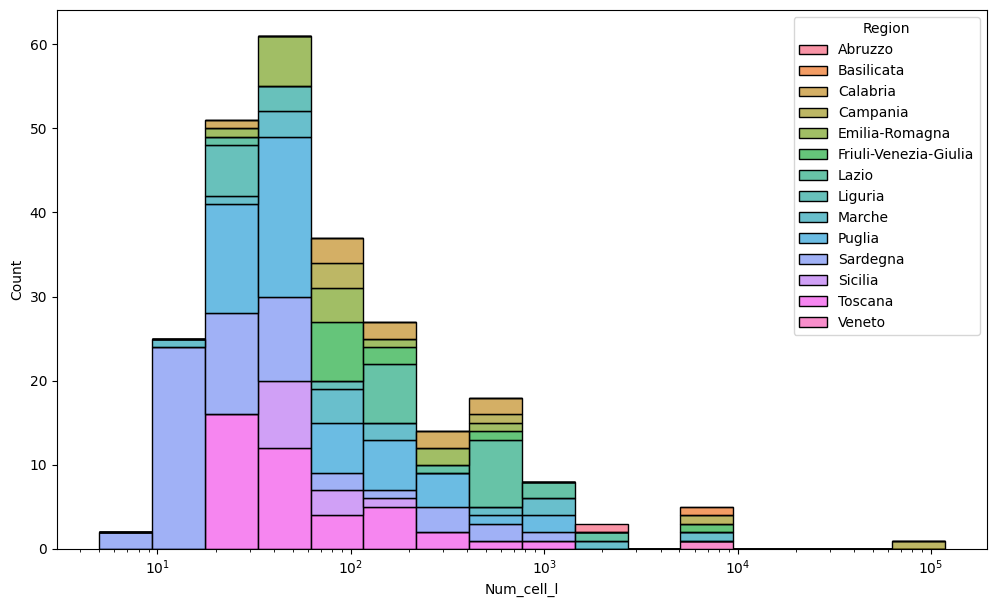

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.set_xscale("log")
sns.histplot(data = species_abund.loc[species_abund["Taxon"].isin(rare_species),:], 
             x = "Num_cell_l", 
             hue = "Region",
             multiple="stack",
             ax = ax
             )

In [31]:
df = phyto_abund_category.query("Det_level == 'Species'").loc[:, "Num_cell_l"]
for fraction in [0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 0.95, 1]: 
    print(df.quantile(fraction))

40.0
40.0
62.0
81.0
150.7964474
603.1857895
8545.000000000015
24119006.0


In [33]:
rel_abund = phyto_abund_simplified[["Region", "id", "Date", "Taxon", "Num_cell_l"]].set_index(["Region", "id", "Date"])
rel_abund["Ratio"] = .0
rel_abund["Ratio"] = rel_abund.loc[:, "Num_cell_l"].div(rel_abund.groupby(level = ["Region", "id", "Date"])["Num_cell_l"].sum())

In [46]:
rel_abund.loc[rel_abund["Taxon"].isin(rare_species),:].sort_values("Ratio", ascending = False).iloc[:150,:]

,,,Taxon,Num_cell_l,Ratio
Region,id,Date,,,
Marche,1E_MS_CH_3,2016-04-07,Planktothrix rubescens,5880.0,0.157645
Calabria,M1T5C,2016-02-23,Protoperidinium steini,80.0,0.105263
Campania,M1CL12,2017-09-06,Rhizosolenia castracanei,80.0,0.095238
Marche,1E_MS_CH_6,2017-07-27,Cocconeis pediculus,1040.0,0.084697
Liguria,VOL060,2017-11-23,Pyrocystis noctiluca,20.0,0.076923
...,...,...,...,...,...
Emilia-Romagna,1014,2017-11-22,Gonyaulax hyalina,40.0,0.000035
Friuli-Venezia-Giulia,ITA06SMLG1,2015-07-21,Nitzschia longissima,160.0,0.000028
Marche,1E_MS_CH_12,2016-03-21,Nitzschia capitellata,111.0,0.000023


## Correlation among species

focused on Sample taken May 2017 (case where all regions sampled)
Kendall tau and Spearman r produced 90% of pairs nto statistically significant

In [ ]:
class Kendall_w(): 
    def __init__(self, a_posteriori : bool = True): 
        self.statistic = None
        self.p_value = None
        if a_posteriori: 
            self.spearman = None
            
    def compute_statistic(self, data: pd.DataFrame): 
        #each column is a judge
        n_objects, n_judges  = data.shape
        ranks = data.rank()
        r_i = ranks.sum(axis = 1)
        S = np.sum((r_i - np.mean(r_i))**2)
        #computing T 
        t_k = np.array([])
        for names, col in ranks.items(): 
            _, n_ties = np.unique(col.values, return_counts=True)
            t_k = np.append(
                t_k,
                n_ties[n_ties > 1]
            )
        T = np.sum(t_k**3 - t_k)
        W = 12 * S / (n_judges**2 * (n_objects**3 - n_objects) - n_judges * T)
        self.statistic = W
        F = (n_judges - 1) * W / (1 - W)
        d1 = n_objects - 1 - 2 / n_judges
        d2 = d1 * (n_judges - 1)
        self.p_value = 1 - stats.f.cdf(F, d1, d2)
    
    def spear2W(self, data : pd.DataFrame): 
        n_objects, n_judges  = data.shape
        r_mean = data.corr("spearman").where(
            np.triu(
                np.ones((n_judges,n_judges), dtype = bool), 
                k = 1
            )
        ).mean()
        return ((n_judges - 1) * r_mean + 1 ) / n_judges
    
    def compute_permutation_p_value(self, data: pd.DataFrame, col2perm: int, r_0 : float, n_perm : int = 999):
        n_objects, n_judges = data.shape
        spear_means = np.zeros(n_perm)
        df_shuffled = data.copy()
        for i in range(n_perm): 
            df_shuffled[col2perm] = np.random.permutation(df_shuffled[col2perm])
            spear_means[i] = np.delete(df_shuffled.corr("spearman")[col2perm], col2perm).mean()
        return np.sum(spear_means[spear_means > r_0]) / n_perm
    
    def a_posteriori(self, data: pd.DataFrame, n_perm : int): 
        n_objects, n_judges  = data.shape
        r_0 = data.corr("spearman").where(~np.identity(n_judges, dtype = bool)).mean().values
        print(r_0)
        p_values = np.vectorize(
            lambda col, r_0: self.compute_permutation_p_value(data, col, r_0, n_perm)
        )(
            range(n_judges),
            r_0
        )
        return pd.DataFrame({"p_vales" : p_values}, index = list(data.columns))

In [ ]:
relative_abund = None
dates = phyto_abund_simplified["Date"]#.between(datetime.datetime(2017,5,1), datetime.datetime(2017,5,31))
for (region_name, df_region) in phyto_abund_simplified.loc[dates, ["Region", "id", "Date", "Taxon", "Num_cell_l"]].groupby("Region"): 
    relative_abund_reg = find_most_representative_species(df_region.drop(columns="Region"), groupby_columns= ["id", "Date"], taxon_column="Taxon",  numeric_column = "Num_cell_l", threshold=1.1, relative_abundance=False)
    relative_abund_reg.reset_index(level = "Taxon", inplace=True)
    relative_abund_reg = relative_abund_reg[~relative_abund_reg["Taxon"].str.contains("Other")]
    relative_abund_reg = pd.pivot_table(relative_abund_reg, index= "id", columns = "Taxon", values="Num_cell_l").fillna(0).T
    relative_abund_reg.columns = pd.MultiIndex.from_tuples((region_name, station_id) for station_id in relative_abund_reg.columns)
    if relative_abund is None: 
        relative_abund = relative_abund_reg
    else: 
        relative_abund = pd.merge(left=relative_abund, right=relative_abund_reg, how = "outer", left_index=True, right_index=True)
relative_abund.fillna(0,inplace=True)
del relative_abund_reg

In [ ]:
relative_abund.T.to_csv("/mnt/d/PHD/real_abund_phyto.csv")

In [ ]:
relative_abund = None
for (region_name, df_region) in phyto_abund_simplified.loc[:, ["Region", "id", "Date", "Taxon", "Num_cell_l"]].groupby("Region"): 
    relative_abund_reg = find_most_representative_species(df_region.drop(columns="Region"), groupby_columns= ["id", "Date"], taxon_column="Taxon",  numeric_column = "Num_cell_l", threshold=1.1, relative_abundance=False)
    relative_abund_reg.reset_index(level = "Taxon", inplace=True)
    relative_abund_reg = relative_abund_reg[~relative_abund_reg["Taxon"].str.contains("Other")]
    relative_abund_reg = pd.pivot_table(relative_abund_reg, index= "id", columns = "Taxon", values="Num_cell_l").fillna(0).T
    relative_abund_reg.columns = pd.MultiIndex.from_tuples((region_name, station_id) for station_id in relative_abund_reg.columns)
    if relative_abund is None: 
        relative_abund = relative_abund_reg
    else: 
        relative_abund = pd.merge(left=relative_abund, right=relative_abund_reg, how = "outer", left_index=True, right_index=True)
relative_abund.fillna(0,inplace=True)
del relative_abund_reg

In [ ]:
df = pd.pivot_table(phyto_abund_simplified.loc[:,["Region", "id", "Date", "Taxon", "Num_cell_l"]], index = ["Region", "id", "Date"], columns = "Taxon", values = "Num_cell_l").fillna(0)

In [ ]:
df.reset_index().to_csv("/mnt/d/PHD/real_abund_phyto_tot.csv", index = False)

In [ ]:
IndVal(relative_abund.T)

In [ ]:
relative_abund.astype(bool).sum(axis=1).describe()

In [ ]:
relative_abund = relative_abund.T.apply(lambda x: np.sqrt(x / sum(x)), axis = 1)

In [ ]:
from scipy.stats import spearmanr

In [ ]:
from scipy import stats

In [ ]:
values = relative_abund.to_numpy().T
N, _ = values.shape
index_p_values = {}
for i in range(N): 
    for j in range(i+1,N):
        p_val = stats.kendalltau(values[i, :], values[j,:], method="asymptotic").pvalue
        if p_val > 0.05: 
            index_p_values[(i,j)] = p_val

In [ ]:
2 * 75529 / (410 * (410-1))

In [ ]:
len(index_p_values)

In [ ]:
p_values = relative_abund.corr(method= lambda a,b: stats.kendalltau(a,b, method="asymptotic").pvalue)

In [ ]:
len(p_values.to_numpy().flatten())

In [ ]:
410**2

In [ ]:
sum(p_values.to_numpy().flatten() < 0.05)

In [ ]:
X = relative_abund.apply(lambda x: (x - np.mean(x)) / np.std(x), axis = 1).to_numpy()


In [ ]:
X = relative_abund.apply(lambda x: (x - np.mean(x)) / np.std(x), axis = 0).to_numpy()
pca = decomposition.PCA(n_components = 2)
pca.fit(X)
df = pd.DataFrame(data = pca.transform(X)[:, [0,1]], columns=["PC1", "PC2"])

In [ ]:
H_clusters = AgglomerativeClustering(n_clusters = 4, metric = "euclidean", linkage = "ward", compute_distances = True)
clusters = H_clusters.fit(X)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
plot_dendrogram(clusters, ax = ax)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
pca.explained_variance_

In [ ]:
df["clusters"] = clusters.labels_

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.scatterplot(df.loc[:, :], x = "PC1", y = "PC2", s = 120, hue = "clusters", palette = "deep")

In [ ]:
spear = relative_abund.corr("spearman")

In [ ]:
spear

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(13, 11))
sns.heatmap(spear, ax = ax)

In [ ]:
H_clusters = AgglomerativeClustering(n_clusters = 4, metric = "precomputed", linkage = "average", compute_distances = True)
clusters = H_clusters.fit((1 - spear)**2)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
plot_dendrogram(clusters, ax = ax , truncate_mode = "level", p = 3
               )
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
X = ((1 - spear)**2).to_numpy()
pca = decomposition.KernelPCA(n_components = 200, kernel="precomputed")
pca.fit(X)
df = pd.DataFrame(data = pca.transform(X)[:, [0,1]], columns=["PC1", "PC2"])

In [ ]:
pca.eigenvalues_[[1,2]] / sum(pca.eigenvalues_)

In [ ]:
df["cluster"] = clusters.labels_

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.scatterplot(df.loc[:, :], x = "PC1", y = "PC2", s = 120, hue = "cluster", palette = "deep")

In [ ]:
relative_abund = None
dates = phyto_abund_simplified["Date"].between(datetime.datetime(2017,5,1), datetime.datetime(2017,5,31))
for (region_name, df_region) in phyto_abund_simplified.loc[dates, ["Region", "id", "Date", "Taxon", "Num_cell_l"]].groupby("Region"): 
    relative_abund_reg = find_most_representative_species(df_region.drop(columns="Region"), groupby_columns= ["id", "Date"], taxon_column="Taxon",  numeric_column = "Num_cell_l", threshold=1.1)
    relative_abund_reg.reset_index(level = "Taxon", inplace=True)
    relative_abund_reg = relative_abund_reg[~relative_abund_reg["Taxon"].str.contains("Other")]
    relative_abund_reg = pd.pivot_table(relative_abund_reg, index= "id", columns = "Taxon", values="Num_cell_l").fillna(0).T
    relative_abund_reg.columns = pd.MultiIndex.from_tuples((region_name, station_id) for station_id in relative_abund_reg.columns)
    if relative_abund is None: 
        relative_abund = relative_abund_reg
    else: 
        relative_abund = pd.merge(left=relative_abund, right=relative_abund_reg, how = "outer", left_index=True, right_index=True)
relative_abund.fillna(0,inplace=True)
del relative_abund_reg

### abundances

In [ ]:
phyto_abundances_per_species = phyto_abund_simplified[["Taxon", "Num_cell_l"]].groupby("Taxon").median().sort_values("Num_cell_l", ascending=False).reset_index()

In [ ]:
n_species = 20
abundance = phyto_abundances_per_species.loc[0:n_species-1, "Num_cell_l"].copy().to_numpy()  
species = phyto_abundances_per_species.loc[0:n_species-1, "Taxon"].copy().to_numpy()
cm, bounds, norm = discrete_colormap(np.arange(n_species),n_species)
fig, ax = plt.subplots(1,1, figsize=(9,6))
ax.set_yscale("log")
for i, (spec, taxon) in enumerate(zip(abundance, species)): 
    ax.bar(i + 1, height = spec, label = taxon, color = cm(i))
ax.legend(loc=(1.04, 0))
ax.set_ylabel("Abundance [cell / l]")
ax.set_xlabel("")
ax.set_title("Abundance of species across Italy, surface level")
ax.set_xticks([i for i in range(1, n_species, 2)]);
#plt.savefig("/mnt/d/PHD/Most_abundant_species.png")

In [ ]:
most_abund_species = ['Skeletonema costatum', 
                      'Chaetoceros socialis', 
                      'Chaetoceros neglectus',
                      'Chaetoceros radicans',
                      ]
#chaetoceros delicatulus observed only once

In [ ]:
df_most_abund_species = phyto_abundances_simplified.loc[phyto_abundances_simplified["Taxon"].isin(most_abund_species), ["id", "Longitude", "Latitude", "Taxon", "Num_cell_l"]].groupby(["id", "Taxon"]).agg({"Longitude" : "first", "Latitude" : "first", "Num_cell_l" : "mean"}).reset_index()

In [ ]:
df_most_abund_species["Num_cell_log"] = df_most_abund_species["Num_cell_l"].apply(np.log10)

In [ ]:
#df_most_abund_species = df_most_abund_species.query("Num_cell_l >= 3.0")
n_rows = len(most_abund_species) // 2 
figsize_dims = (12,10)
fig, axs = plt.subplots(n_rows,2, figsize=figsize_dims);
axs = axs.flat[:len(most_abund_species)+1]

for ax, (name, df) in zip(axs, df_most_abund_species.groupby(by = "Taxon")): 
    cm, bounds, norm = discrete_colormap(df["Num_cell_log"].to_numpy(), 15);
    plot_italian_coast(ax, (x_pen, x_sic, x_sard), (y_pen, y_sic, y_sard), alpha = 0.7);
    sc = ax.scatter(*df[["Longitude", "Latitude"]].to_numpy().T, c = df["Num_cell_log"].to_numpy(), cmap = cm, norm = norm, s = 20);
    ax.set_xlim(df["Longitude"].min() * 0.99, df["Longitude"].max() * 1.01)
    ax.set_ylim(df["Latitude"].min() * 0.99, df["Latitude"].max() * 1.01)
    ax.set_xlabel("Longitude");
    ax.set_ylabel("Latitude");
    ax.set_title(name);
    plt.colorbar(sc, cmap=cm, norm=norm,
        spacing='proportional', ticks=bounds, boundaries=bounds, format='%2.2f', label = "log((# individuals) / l)");
plt.tight_layout()
plt.show()

In [ ]:
phyto_abundances_per_genus = phyto_abundances_simplified[["Genus", "Num_cell_l"]].groupby("Genus").median().sort_values("Num_cell_l", ascending=False).reset_index()

In [ ]:
n_species = 20
abundance = phyto_abundances_per_genus.loc[0:n_species-1, "Num_cell_l"].copy().to_numpy()  
order_of_magnitude = floor(abs(np.log10(abundance.max())))
abundance /= 10 ** order_of_magnitude
species = phyto_abundances_per_genus.loc[0:n_species-1, "Genus"].copy().to_numpy()
cm, bounds, norm = discrete_colormap(np.arange(n_species),n_species)
fig, ax = plt.subplots(1,1, figsize=(9,6))
for i, (spec, taxon) in enumerate(zip(abundance, species)): 
    ax.bar(i + 1, height = spec, label = taxon, color = cm(i))
ax.legend(loc=(1.04, 0))
ax.set_ylabel(r"Abundance (ind. / l) $\times 10^{}$".format(order_of_magnitude))
ax.set_xlabel("")
ax.set_title("Abundance of species across Italy (averages over time and " + r"depth$ = 0 \; m$)")
ax.set_xticks([i for i in range(1, n_species, 2)]);
#plt.savefig("/mnt/d/PHD/Most_abundant_species.png")

computer IndVal, first station-wise and check if any species is particularly present in a region 

In [ ]:
IndVal_italy = None 
for (region_name, df_region) in phyto_abund_simplified[["Region", "id", "Date", "Taxon", "Num_cell_l"]].groupby("Region"): 
    relative_abund = find_most_representative_species(df_region.drop(columns="Region"), groupby_columns= ["id", "Date"], taxon_column="Taxon",  numeric_column = "Num_cell_l", threshold=1.1)
    relative_abund.reset_index(level = "Taxon", inplace=True)
    relative_abund = relative_abund[~relative_abund["Taxon"].str.contains("Other")]
    relative_abund = pd.pivot_table(relative_abund, index= ["id", "Date"], columns = "Taxon", values="Num_cell_l").fillna(0)
    IndVal_reg = IndVal(relative_abund).T
    IndVal_reg.columns = pd.MultiIndex.from_tuples((region_name, station_id) for station_id in IndVal_reg.columns)
    if IndVal_italy is None: 
        IndVal_italy = IndVal_reg
    else: 
        IndVal_italy = pd.merge(left=IndVal_italy, right=IndVal_reg, how = "outer", left_index=True, right_index=True)
IndVal_italy.fillna(0,inplace=True)
del df_region
del relative_abund
del IndVal_reg

In [ ]:
IndVal_italy.loc[IndVal_italy.loc[:, ("Abruzzo", "1_ABR_GU04")] != 0, ("Abruzzo", "1_ABR_GU04")]

find N species having highest IndVal for each station 

In [ ]:
n_largest = 5
IndVal_species = pd.DataFrame(columns=IndVal_italy.columns)
for station  in IndVal_italy.columns: 
    IndVal_species[station] = IndVal_italy[station].nlargest(n_largest).index

In [ ]:
regions = IndVal_species.columns.get_level_values(0).unique()
for region in regions: 
    taxons, count = np.unique(IndVal_species[region].to_numpy().flatten(), return_counts=True)
    print(f"{region}: {*taxons[count.argsort()],}" )

In [ ]:
for region in regions:
    print(region)
    print(IndVal_italy[region].idxmax())

In [ ]:
taxons, counts = np.unique(IndVal_species.to_numpy().flatten(), return_counts = True)

In [ ]:
pd.DataFrame(index=taxons, data = {"count" : counts}).sort_values("count", ascending = False).iloc[:20]

In [ ]:
pd.DataFrame(index=taxons, data = {"count" : counts}).sort_values("count", ascending = False).iloc[:30].plot(kind = "bar")

perform PCA on IndVal

In [ ]:
X = IndVal_italy.to_numpy().T
X = np.sqrt(X / np.sum(X, axis = 1)[:, None])
kpca = decomposition.KernelPCA(n_components=2)
kpca.fit(X)
df = pd.DataFrame(data = kpca.transform(X), columns=["PC1", "PC2"])
df["Region"] = IndVal_italy.columns.get_level_values(0)


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.scatterplot(df, x = "PC1", y = "PC2", hue = "Region", palette = "deep", ax = ax, style = "Region", s = 120)

Hireranchical clustering

In [ ]:
X = IndVal_italy.to_numpy().T
X = np.sqrt(X / np.sum(X, axis = 1)[:, None])
model = AgglomerativeClustering(linkage="ward", compute_distances=True, n_clusters = 8).fit(X)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
plot_dendrogram(model, ax = ax)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
colors = make_colors_from_labels(model.labels_)
cm, bounds, norm = discrete_colormap(model.labels_)
plot_italian_coast(ax, (x_pen, x_sic, x_sard), (y_pen, y_sic, y_sard), alpha = 0.5)
sc = ax.scatter(*df_lat_long_stations.set_index("id").loc[IndVal_italy.columns.get_level_values(1).to_list(), ["Longitude", "Latitude"]].to_numpy().T, c = model.labels_, cmap = cm, norm = norm)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.colorbar(sc, cmap=cm, norm=norm,
    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i', label = "# of species")
plt.show()